# Read files

In [1]:
%config Completer.use_jedi = False

In [2]:
# import libraries
import numpy as np
import pandas as pd
import os, h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from jason import jason_plotting as plotting
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/jasonwu/Programs/codes/def.mplstyle')
plotting.plot_prettier(dpi=400,usetex=False)
%matplotlib inline

In [3]:
# global variables
ECALZ_MIN = 247.9
ECALZ_MAX = 749.1
ECALW = 520

BHCALZ_MIN = 879
SHCALZ_MIN = 240
SHCALZ_MAX = 800
SHCALX_MIN = 500
SHCALX_MAX = 1500

# the style used for the confidence range plots
# 0: area
# 1: error bars
style = 1

def plot_ecal_box(ax, label=False):
    box_label = 'ECal' if label else ''
    ax.add_patch(plt.Rectangle((ECALZ_MIN, -ECALW/2), ECALZ_MAX - ECALZ_MIN, ECALW, fc=(0, 0, 0, 0), ec='red', label=box_label))
    
def plot_hcal_box(ax, label=False):
    box_label = 'HCal' if label else ''
    ax.add_patch(plt.Rectangle((SHCALZ_MIN, SHCALX_MIN), SHCALZ_MAX - SHCALZ_MIN, SHCALX_MAX - SHCALX_MIN, fc=(0, 0, 0, 0), ec='red', label=box_label))
    ax.add_patch(plt.Rectangle((SHCALZ_MIN, -SHCALX_MAX), SHCALZ_MAX - SHCALZ_MIN, SHCALX_MAX - SHCALX_MIN, fc=(0, 0, 0, 0), ec='red', label=box_label))
    ax.axvline(x=BHCALZ_MIN, lw=1, ls='--', color='red', label=box_label)

In [4]:
labels_keys = 'electrons neutrons photons pions protons electrons_hcal neutrons_hcal photons_hcal pions_hcal protons_hcal'.split(' ')
labels_values = [
    r'Electrons $e^{\minus}$',
    r'Neutrons $n^{o}$',
    r'Photons $\gamma$',
    r'Pions $\pi^{\minus}$',
    r'Protons $p^{\plus}$',
    r'Electrons $e^{\minus}$ HCal',
    r'Neutrons $n^{o}$ HCal',
    r'Photons $\gamma$ HCal',
    r'Pions $\pi^{\minus}$ HCal',
    r'Protons $p^{\plus}$ HCal'
]

labels_dict = {labels_keys[i]: labels_values[i] for i in range(len(labels_keys))}

In [5]:
# initiate a particle class
class Particles():
    def __init__(self, hf, zero_on='PFTruthTarget_energy'):
        # a list of properties
        self.propdict = {}
        # initiate all properties
        for prop in hf.keys():
            # convert to numpy array
            self.propdict[prop] = hf[prop][()]
        self._clean_props(zero_on)
    
    # clean the data set
    def _clean_props(self, zero_on='PFTruthTarget_energy'):
        # remove on column
        if isinstance(zero_on, list):
            # invalid energy values
            zero_bool_mask = np.array(self.propdict[zero_on[0]] <= 0)
            for zero_col in zero_on[1:]:
                zero_bool_mask = np.logical_and(zero_bool_mask, np.array(self.propdict[zero_col] <= 0))
        else:
            zero_bool_mask = np.array(self.propdict[zero_on] <= 0)
            
        print(f'{np.sum(zero_bool_mask)} values removed from {zero_on}')
        
        for prop in list(self.propdict.keys()):
            nan_bool_mask = np.isnan(self.propdict[prop])
            if np.any(nan_bool_mask):
                print(f'{np.sum(nan_bool_mask):<10} NaN values for {prop}')
                # set the values to zero
                self.propdict[prop][np.isnan(self.propdict[prop])] = 0
            self.propdict[prop] = self.propdict[prop][~zero_bool_mask]
                
        print('\n')
    
    # return a property
    def get(self, prop = None):
        if prop is not None:  # if specific property(ies) are given
            if isinstance(prop, list):
                prop_list = []
                for single_prop in prop:
                    prop_list.append(self.propdict[single_prop])
                return prop_list
            else:
                assert prop in list(self.propdict.keys())
                return self.propdict[prop]
        else:
            return self.propdict
    
    # account for mass of particle
    def acc_mass(self, mass, columns=[]):
        # subtract mass
        for column in columns:
            self.propdict[column] = np.clip(self.propdict[column] - mass, 0, None)
    
    # return a list of all properties
    def list_props(self):        
        print(f'{"Property Name":<30}{"Number of Entries":<20}{"Unique Entries":<20}{"Range":<30}{"Mean"}')
        
        for prop in list(self.propdict.keys()):
            print(f'{prop: <30}{len(self.propdict[prop]):<20}{len(np.unique(self.propdict[prop])):<8}\
            {np.min(self.propdict[prop]):<10.2f}{np.max(self.propdict[prop]):>8.2f}\
            {np.mean(self.propdict[prop]):<.2f}')
        print('\n')
        return list(self.propdict.keys())
    
    # apply a correction to the ecal and hcal energy measurements
    def o1corr_energy(self, verbose=True, scheme='nearest',  # three schemes 'none', 'nearest' and 'spline'
                      energy_bins_ecal=[0, 6e3], o1corr_ecal=[1],
                      energy_bins_hcal=[0, 6e3], o1corr_hcal=[1],
                      numbins=20, gev=True, label=labels_dict['photons']):
        # correct the energies
        match scheme:  # different schemes to handle values outside of measured bins
            case 'none':  # set to NaN, breaks plots
                # ecal
                o1corr_ecal = pd.cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal,
                                     include_lowest=True, labels=o1corr_ecal).to_numpy()
                # hcal
                o1corr_hcal = pd.cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal,
                                     include_lowest=True, labels=o1corr_hcal).to_numpy()
            case 'nearest':  # sets to value of nearest bin
                def nearest_cut(data, bins=[0, 6e3], labels=[1]):
                    # assigns labels to data based on bins
                    label_ind = np.digitize(data, bins=bins, right=True)
                    # contains 0 and len(labels)
                    label_ind[label_ind == 0] = 1  # label_ind will start at 1
                    label_ind[label_ind == len(bins)] = len(labels)  # set to maximum ind
                    return labels[label_ind - 1]
                # ecal
                o1corr_ecal = nearest_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = nearest_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
            case 'spline':
                def spline_cut(data, bins=[0, 6e3], labels=[1]):
                    # construct spline object for bin centers
                    bin_centers = [(a + b) / 2 for a, b in zip(bins[::], bins[1::])] # average of two consecutive elements in bins
                    # calculate splined values for data
                    splined_coeff, _ = plotting.spline_xy(bin_centers, labels, data)
                    return splined_coeff
                    
                # ecal
                o1corr_ecal = spline_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = spline_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
                
        energy_o1corr_ecal = self.get('PFCandidates_ecalEnergy') * o1corr_ecal
        energy_o1corr_hcal = self.get('PFCandidates_hcalEnergy') * o1corr_hcal
        
        
        # total
        energy_o1corr_total = energy_o1corr_ecal + energy_o1corr_hcal
        
        # set the dictionary entries
        self.propdict['PFCandidates_ecalEnergy_o1corr'] = energy_o1corr_ecal
        self.propdict['PFCandidates_hcalEnergy_o1corr'] = energy_o1corr_hcal
        self.propdict['PFCandidates_energy_o1corr'] = energy_o1corr_total
        
        # O(1) correction comparison plot with both energies
        if verbose:
            fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
            # set the truth energy depending on the type of particle simulation
            if (label is not None) and \
               ('HCal' in label):
                # if the particle went through both ecal and hcal
                print('HCal energy set to truth')
                energy_truth_total = self.get('PFTruthHcal_energy')  # the pre-hcal energy is set to truth
            else:
                print('Target energy set to truth')
                energy_truth_total = self.get('PFTruthTarget_energy')  # the pre-target energy is set to truth

            if gev:  # plot x axis in gev instead
                plt.xlim([0, 4])
                plt.xlabel('Truth Total Energy [GeV]')
                x = energy_truth_total/1e3
                textx = 3.5
            else:  # plot x axis in mev
                plt.xlim([0, 4000])
                plt.xlabel('Truth Total Energy [MeV]')
                x = energy_truth_total
                textx = 3500
            y1 = self.get('PFCandidates_energy')/energy_truth_total  # measured ratio
            y2 = energy_o1corr_total/energy_truth_total  # reconstructed ratio
            _ = plotting.percentile(x, y1, numbins=numbins, style=style,
                                    color='red', label='Measured', textpos=[textx, 1.5])
            _ = plotting.percentile(x, y2, numbins=numbins, style=style,
                                    color='blue', label='$\mathcal{O}(1)$ Reconstructed')
            plt.ylabel('Reconstructed / Truth Total Energy', fontsize=10)
            plt.legend(loc='upper right')
            plt.ylim([0, 2])
            plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=7, weight='bold')

        return energy_o1corr_ecal, energy_o1corr_hcal, energy_o1corr_total

## Dictionaries

In [6]:
# HCal particles
hcal_particles_dict = {
    'electrons_hcal': None,
    'photons_hcal': None,
    'neutrons_hcal': None,
    'pions_hcal': None,
    'protons_hcal': None
}

# ECal + HCal particles
both_particles_dict = {
    'electrons': None,
    'photons': None,
    'neutrons': None,
    'pions': None,
    'protons': None
}

In [7]:
import pickle

# dump the particles into pickle files
for file_name in hcal_particles_dict.keys():
    with open(f"data/pickles/{file_name}.pkl", 'rb') as handle:
        data = handle.read()
    hcal_particles_dict[file_name] = pickle.loads(data)

for file_name in both_particles_dict.keys():
    with open(f"data/pickles/{file_name}.pkl", 'rb') as handle:
        data = handle.read()
    both_particles_dict[file_name] = pickle.loads(data)

In [8]:
electrons_hcal = hcal_particles_dict['electrons_hcal']
photons_hcal = hcal_particles_dict['photons_hcal']
neutrons_hcal = hcal_particles_dict['neutrons_hcal']
pions_hcal = hcal_particles_dict['pions_hcal']
protons_hcal = hcal_particles_dict['protons_hcal']

electrons = both_particles_dict['electrons']
photons = both_particles_dict['photons']
neutrons = both_particles_dict['neutrons']
pions = both_particles_dict['pions']
protons = both_particles_dict['protons']

In [9]:
_ = electrons_hcal.list_props()

Property Name                 Number of Entries   Unique Entries      Range                         Mean
PFCandidates_ecalClusterDXDZ  10000               4                   -0.12         0.04            -0.00
PFCandidates_ecalClusterDYDZ  10000               4                   0.00          0.05            0.00
PFCandidates_ecalClusterEDXDZ 10000               4                   0.00          0.00            0.00
PFCandidates_ecalClusterEDYDZ 10000               4                   0.00          0.00            0.00
PFCandidates_ecalClusterEX    10000               39                  0.00        156.32            0.18
PFCandidates_ecalClusterEY    10000               36                  0.00        181.89            0.16
PFCandidates_ecalClusterEZ    10000               17                  0.00        247.29            0.15
PFCandidates_ecalClusterX     10000               231                 -253.37     255.78            0.51
PFCandidates_ecalClusterY     10000               162 

# Plotting Spatial Distributions

## Plotting Hits

In [10]:
# import libraries
import numpy as np
import awkward as ak  # damn array be like me fr fr
import pandas as pd 
import os, h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from jason import jason_plotting as plotting
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/jasonwu/Programs/codes/def.mplstyle')
plotting.plot_prettier(dpi=400,usetex=False)
%matplotlib inline
import uproot


# global variables
ECALZ_MIN = 247.9
ECALZ_MAX = 749.1
ECALW = 260

HCALZ_MIN = 879

# the style used for the confidence range plots
# 0: area
# 1: error bars
style = 1

In [11]:
def get_data(file_name = 'pf.ele_0p1_4GeV.10k.1part.7.15cm.root',
             root_trial = 'pfSamples_230801',
             root_dir = '/Users/jasonwu/Programs/Fermilab/run_data',
             # the branches to include in the output
             included_branches = ['PFEcalClusters_pf', 'PFHcalClusters_pf', 'PFTracks_pf', 'PFCandidates_pf', 'PFTruth_pf', 'PFTruthTarget_pf', 'PFTruthEcal_pf', 'PFTruthHcal_pf'],
             # the branches to save directly
             saved_branches = ['EcalTotalEnergy_pf', 'HcalTotalEnergy_pf', 'PFTruth_pf/PFTruth_pf.second.vertexVolume_'],
             # if True, generates leading cluster properties
             lead_clust = False,
             # the branches to do leading cluster on
             lead_clust_branches = ['PFEcalClusters_pf', 'PFHcalClusters_pf'],
             lead_clust_override = False,
             # if True, prints type and number of points in each property
             verbose = False):
    file = uproot.open(f'{root_dir}/{root_trial}/pf/{file_name}')
    events = file['LDMX_Events']
    # all the keys in events
    keys = np.array(events.keys())
    save_mask = np.array([1 if (branch in saved_branches) else 0 for branch in keys]).astype(bool)
    keys = np.delete(keys, save_mask)
    # branches
    branch_mask = np.array([0 if ('/' in branch) else 1 for branch in keys]).astype(bool)
    branches = keys[branch_mask]
    branch_ind = np.append(np.where(branch_mask == 1)[0], -1)
                 
    if lead_clust_override:
        suffix_new = ''
        suffix_og = '_og'
    else:
        suffix_new = '_lc'
        suffix_og = ''
                 
    prop_dict = {}


    # save the branches directly
    for branch in saved_branches:  # check if within directly saved branch
        if verbose: print(f'{branch} is saved directly')
        saved_prop = np.array(events[branch])
        prop_dict[branch.replace('_pf', '')] = saved_prop
        
    for i in range(len(branches)):
        branch = branches[i]
        if branch in included_branches:  # check if within included branch
            if verbose: print(f'{branch} is included')
            # get all the nodes of the branch
            branch_nodes = keys[branch_ind[i]+1:] if branch_ind[i+1] == -1 else keys[branch_ind[i]+1 : branch_ind[i+1]]
            if verbose: print(branch_nodes)

            # get the energy indices for leading cluster anlaysis
            if lead_clust and (branch in lead_clust_branches):
                energy_node = f'{branch}/{branch}.energy_'  # string of the energy node
                # the awkward array corresponding to energy
                energy_prop = events[energy_node].array(library='ak')
                energy_prop = ak.values_astype(energy_prop, np.float64)
                # the indices corresponding to maximum energy (in case unsorted)
                max_ind = ak.argmax(energy_prop, axis=1, keepdims=True, mask_identity=True)
                
            # for each node in the branch
            for branch_node in branch_nodes:
                # make the awkward array
                prop = events[branch_node].array(library='ak')
                # pad the array with at least one entry
                prop = ak.pad_none(prop, 1, axis=1)

                # check if consisting of empty arrays
                if len(ak.ravel(prop)) == 0 or not ak.any(ak.ravel(prop)):  # effectively empty
                    # flatten the array into zeros
                    if verbose: print(f'Empty array at {branch_node}, reduced to zeroes')
                    prop_flat = np.zeros(len(prop))
                    if verbose: print(prop_flat.shape)

                    prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_')] = prop_flat
                elif len(ak.ravel(prop)) == len(prop):  # effectively one-dimensional
                    if verbose: print(f'One-dimensional array at {branch_node}, reduced to numpy')
                    prop_flat = ak.to_numpy(ak.ravel(prop), allow_missing=True).astype(float).filled(np.nan)
                    if verbose: print(prop_flat.shape)

                    prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_')] = prop_flat
                else:
                    # if the array is truly jagged
                    if verbose: print(f'Jagged/partially empty array at {branch_node}')
                    prop_flat = prop
                    if verbose: print(prop_flat.type)

                    # construct a leading cluster array
                    if lead_clust and (branch in lead_clust_branches):
                        # mask the array with max energy indices
                        max_prop = prop_flat[ak.from_regular(max_ind)]
                        # flatten, convert to numpy array, and fill with nan
                        # handles hit info
                        if 'hit' in branch_node:
                            # unravel max_prop
                            max_prop = ak.Array([np.array(_[0]) for _ in max_prop])
                            prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_') + suffix_new] = max_prop  # take out into lc data
                            prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_') + suffix_og] = prop_flat
                        else:
                            max_prop_flat = ak.to_numpy(ak.ravel(max_prop), allow_missing=True).astype(float)
                            max_prop_flat = max_prop_flat.filled(np.nan)
                            prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_') + suffix_new] = max_prop_flat  # lc data
                            prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_') + suffix_og] = prop_flat
                    else:  # no leading cluster array
                        prop_dict[branch_node.split('/')[1].replace('_pf', '')[:-1].replace('.', '_')] = prop_flat

        else:
            if verbose: print(f'{branch} is not included')
    return prop_dict

In [12]:
root_trial = 'pfSamples_230801'
test_part = get_data(file_name='pf.ele_0p1_4GeV.10k.1part.7.15cm.root', root_trial=root_trial,
                     lead_clust=True, lead_clust_branches=['PFEcalClusters_pf'], lead_clust_override=False)
list(test_part.keys())

['EcalTotalEnergy',
 'HcalTotalEnergy',
 'PFTruth/PFTruth.second.vertexVolume_',
 'PFEcalClusters_hitIDs',
 'PFEcalClusters_energy_lc',
 'PFEcalClusters_energy',
 'PFEcalClusters_nHits_lc',
 'PFEcalClusters_nHits',
 'PFEcalClusters_centroidX_lc',
 'PFEcalClusters_centroidX',
 'PFEcalClusters_centroidY_lc',
 'PFEcalClusters_centroidY',
 'PFEcalClusters_centroidZ_lc',
 'PFEcalClusters_centroidZ',
 'PFEcalClusters_rmsX_lc',
 'PFEcalClusters_rmsX',
 'PFEcalClusters_rmsY_lc',
 'PFEcalClusters_rmsY',
 'PFEcalClusters_rmsZ_lc',
 'PFEcalClusters_rmsZ',
 'PFEcalClusters_DXDZ',
 'PFEcalClusters_DYDZ',
 'PFEcalClusters_errDXDZ',
 'PFEcalClusters_errDYDZ',
 'PFEcalClusters_hitX_lc',
 'PFEcalClusters_hitX',
 'PFEcalClusters_hitY_lc',
 'PFEcalClusters_hitY',
 'PFEcalClusters_hitZ_lc',
 'PFEcalClusters_hitZ',
 'PFEcalClusters_hitE_lc',
 'PFEcalClusters_hitE',
 'PFHcalClusters_hitIDs',
 'PFHcalClusters_energy',
 'PFHcalClusters_nHits',
 'PFHcalClusters_centroidX',
 'PFHcalClusters_centroidY',
 'PFHcal

In [13]:
ecal_hitx_tot, ecal_hitz_tot = [], []
for ecal_x, ecal_z in zip(test_part['PFEcalClusters_hitX'], test_part['PFEcalClusters_hitZ']):
    ecal_hitx_tot = np.hstack([ecal_hitx_tot, ak.to_numpy(ak.ravel(ecal_x))])
    ecal_hitz_tot = np.hstack([ecal_hitz_tot, ak.to_numpy(ak.ravel(ecal_z))])
    
hcal_hitx_tot, hcal_hitz_tot = [], []
for hcal_x, hcal_z in zip(test_part['PFHcalClusters_hitX'], test_part['PFHcalClusters_hitZ']):
    hcal_hitx_tot = np.hstack([hcal_hitx_tot, ak.to_numpy(ak.ravel(hcal_x))])
    hcal_hitz_tot = np.hstack([hcal_hitz_tot, ak.to_numpy(ak.ravel(hcal_z))])

Axes limits [0, 1500] and [-1000, 1000]
Axes limits [0, 1500] and [-1000, 1000]


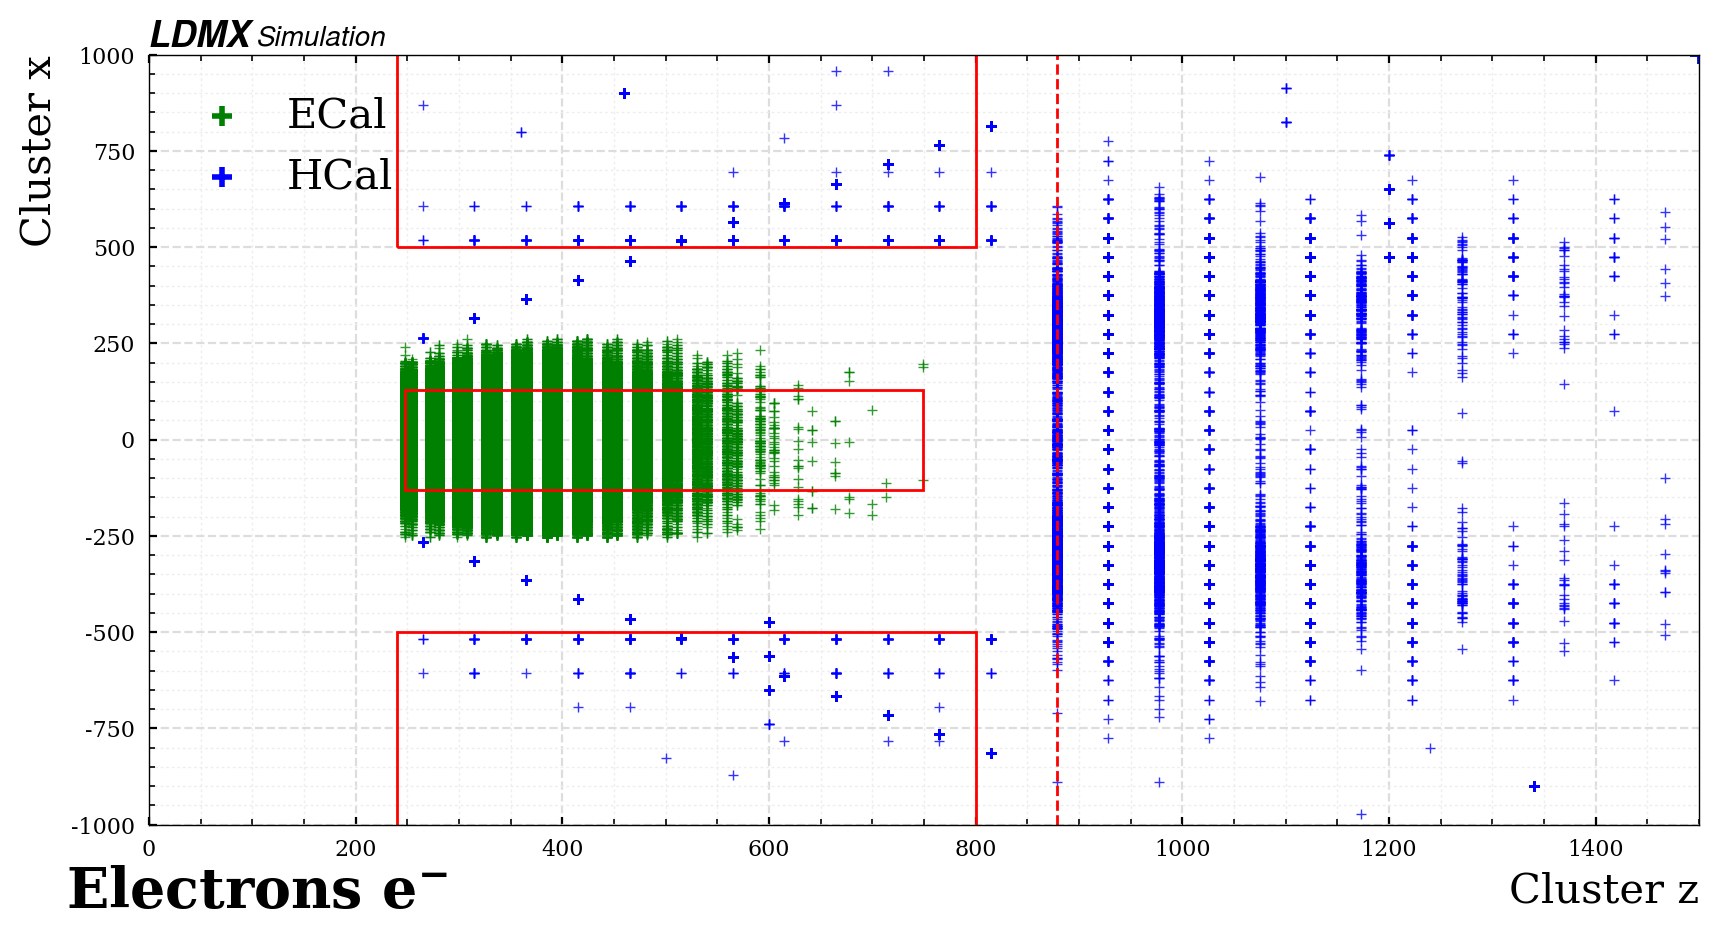

In [14]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
plotting.style_ldmx(fig, ax)
# plotting.hist2d(fig, ax,
#                 ecal_hitz_tot,
#                 ecal_hitx_tot,
#                 xlim=[250, 450],
#                 ylim=[-150, 150],
#                 xlabel='ECal cluster z',
#                 ylabel='ECal cluster x',
#                 binsize=10)
# plotting.hist2d(fig, ax,
#                 hcal_hitz_tot,
#                 hcal_hitx_tot,
#                 xlim=[250, 1200],
#                 ylim=[-1000, 1000],
#                 xlabel='Cluster z',
#                 ylabel='Cluster x',
#                 cbar_prop=None,
#                 binsize=10)
plotting.scatter(fig, ax,
                 ecal_hitz_tot, ecal_hitx_tot,
                 s = 15, lw = 0.5, c = 'green', a = 0.8,
                 xlim=[0, 1500], ylim=[-1000, 1000],
                 label='ECal',
                 draw_line=False,
                 xlabel='Cluster z', ylabel='Cluster x')
plotting.scatter(fig, ax,
                 hcal_hitz_tot, hcal_hitx_tot,
                 s = 15, lw = 0.5, c = 'blue', a = 0.8,
                 xlim=[0, 1500], ylim=[-1000, 1000],
                 label='HCal',
                 draw_line=False,
                 xlabel='Cluster z', ylabel='Cluster x')
plot_ecal_box(ax)
plot_hcal_box(ax)
ax.annotate(text=labels_dict['electrons'], xy=(-30, -30), xycoords='axes points', fontsize=20, weight='bold')
plt.legend(fontsize=15, loc='upper left')
plt.show()

## Plotting Cluster Centroids

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Axes limits [-150, 150] and [-150, 150]


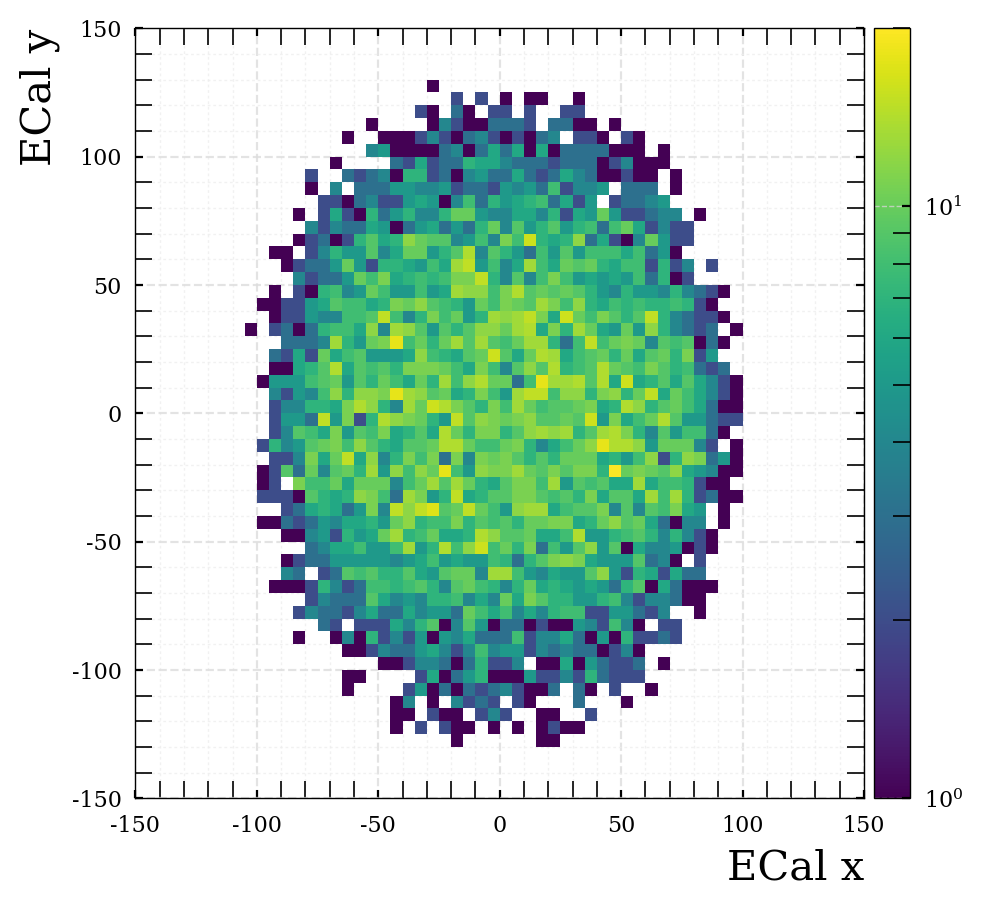

In [15]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
plotting.hist2d(fig, ax,
                photons.get('PFCandidates_posEcalX'),
                photons.get('PFCandidates_posEcalY'),
                xlim=[-150, 150],
                ylim=[-150, 150],
                xlabel='ECal x',
                ylabel='ECal y',
                binsize=5)
plt.show()

## Comparing Different Particles

### Electrons

Axes limits [250, 450] and [-150, 150]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Axes limits [250, 1200] and [-1000, 1000]


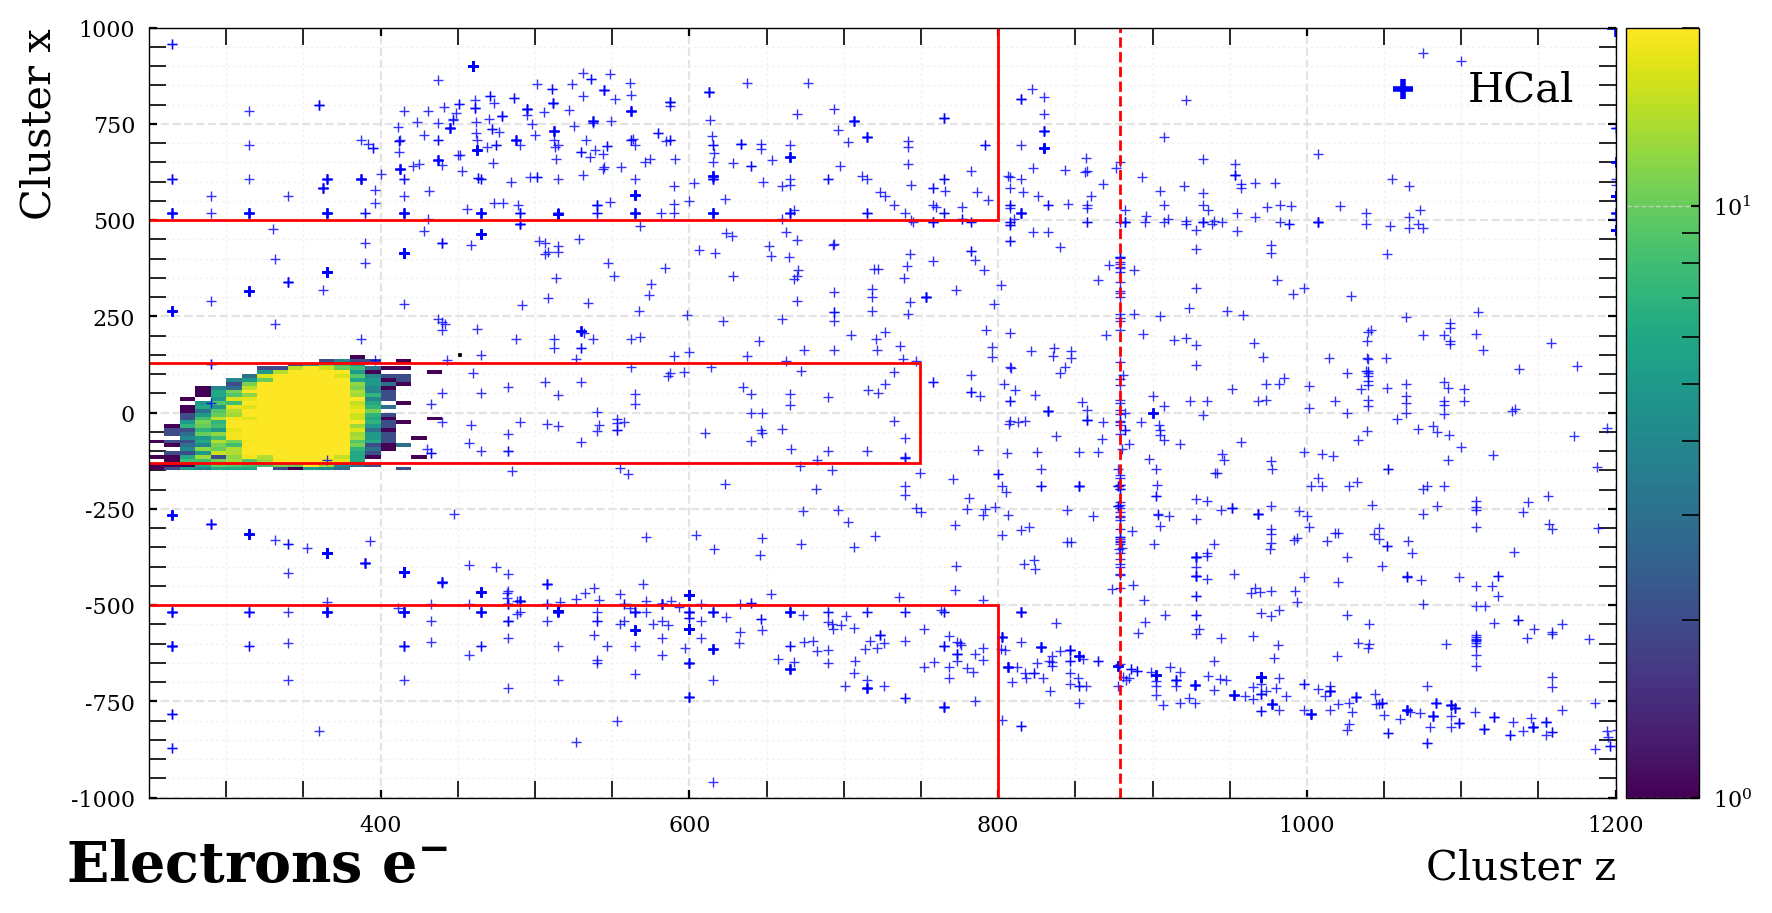

In [16]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
plotting.hist2d(fig, ax,
                electrons.get('PFCandidates_ecalClusterZ'),
                electrons.get('PFCandidates_ecalClusterX'),
                xlim=[250, 450],
                ylim=[-150, 150],
                xlabel='ECal cluster z',
                ylabel='ECal cluster x',
                binsize=10)
# plotting.hist2d(fig, ax,
#                 electrons.get('PFCandidates_hcalClusterZ'),
#                 electrons.get('PFCandidates_hcalClusterX'),
#                 xlim=[250, 1200],
#                 ylim=[-1000, 1000],
#                 xlabel='Cluster z',
#                 ylabel='Cluster x',
#                 cbar_prop=None,
#                 binsize=10)
plotting.scatter(fig, ax,
                 electrons.get('PFCandidates_hcalClusterZ'), electrons.get('PFCandidates_hcalClusterX'),
                 s = 15, lw = 0.5, c = 'blue', a = 0.8,
                 xlim=[250, 1200], ylim=[-1000, 1000],
                 label='HCal',
                 draw_line=False,
                 xlabel='Cluster z', ylabel='Cluster x')
plot_ecal_box(ax)
plot_hcal_box(ax)
ax.annotate(text=labels_dict['electrons'], xy=(-30, -30), xycoords='axes points', fontsize=20, weight='bold')
plt.legend(fontsize=15)
plt.show()

### Neutrons

Axes limits [250, 1200] and [-1000, 1000]
Axes limits [250, 1200] and [-1000, 1000]


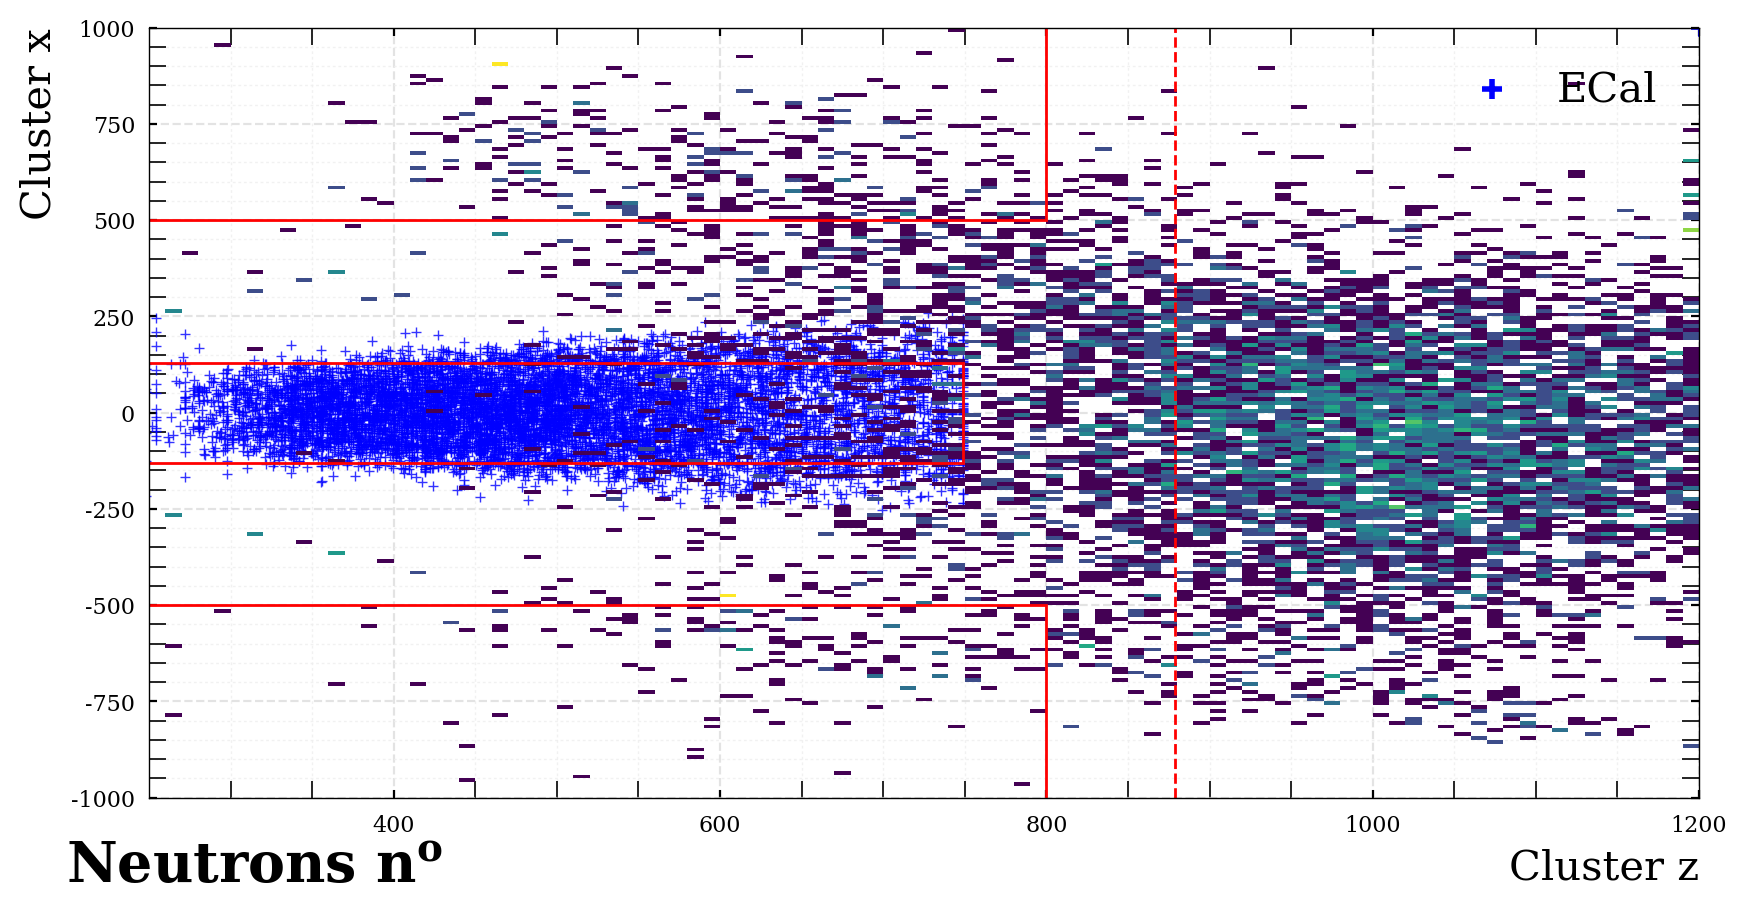

In [17]:

fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
# plotting.hist2d(fig, ax,
#                 neutrons.get('PFCandidates_ecalClusterZ'),
#                 neutrons.get('PFCandidates_ecalClusterX'),
#                 xlim=[250, 1000],
#                 ylim=[-150, 150],
#                 xlabel='ECal cluster z',
#                 ylabel='ECal cluster x',
#                 binsize=10)
plotting.scatter(fig, ax,
                 neutrons.get('PFCandidates_ecalClusterZ'), neutrons.get('PFCandidates_ecalClusterX'),
                 s = 15, lw = 0.5, c = 'blue', a = 0.8,
                 xlim=[250, 1200], ylim=[-1000, 1000],
                 label='ECal',
                 draw_line=False,
                 xlabel='Cluster z', ylabel='Cluster x')
plotting.hist2d(fig, ax,
                neutrons.get('PFCandidates_hcalClusterZ'),
                neutrons.get('PFCandidates_hcalClusterX'),
                xlim=[250, 1200],
                ylim=[-1000, 1000],
                xlabel='Cluster z',
                ylabel='Cluster x',
                cbar_prop=None,
                binsize=10)
plot_ecal_box(ax)
plot_hcal_box(ax)
plt.legend(fontsize=15)
ax.annotate(text=labels_dict['neutrons'], xy=(-30, -30), xycoords='axes points', fontsize=20, weight='bold')
plt.show()

### Photons

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Axes limits [250, 600] and [-150, 150]
Axes limits [250, 1200] and [-1000, 1000]


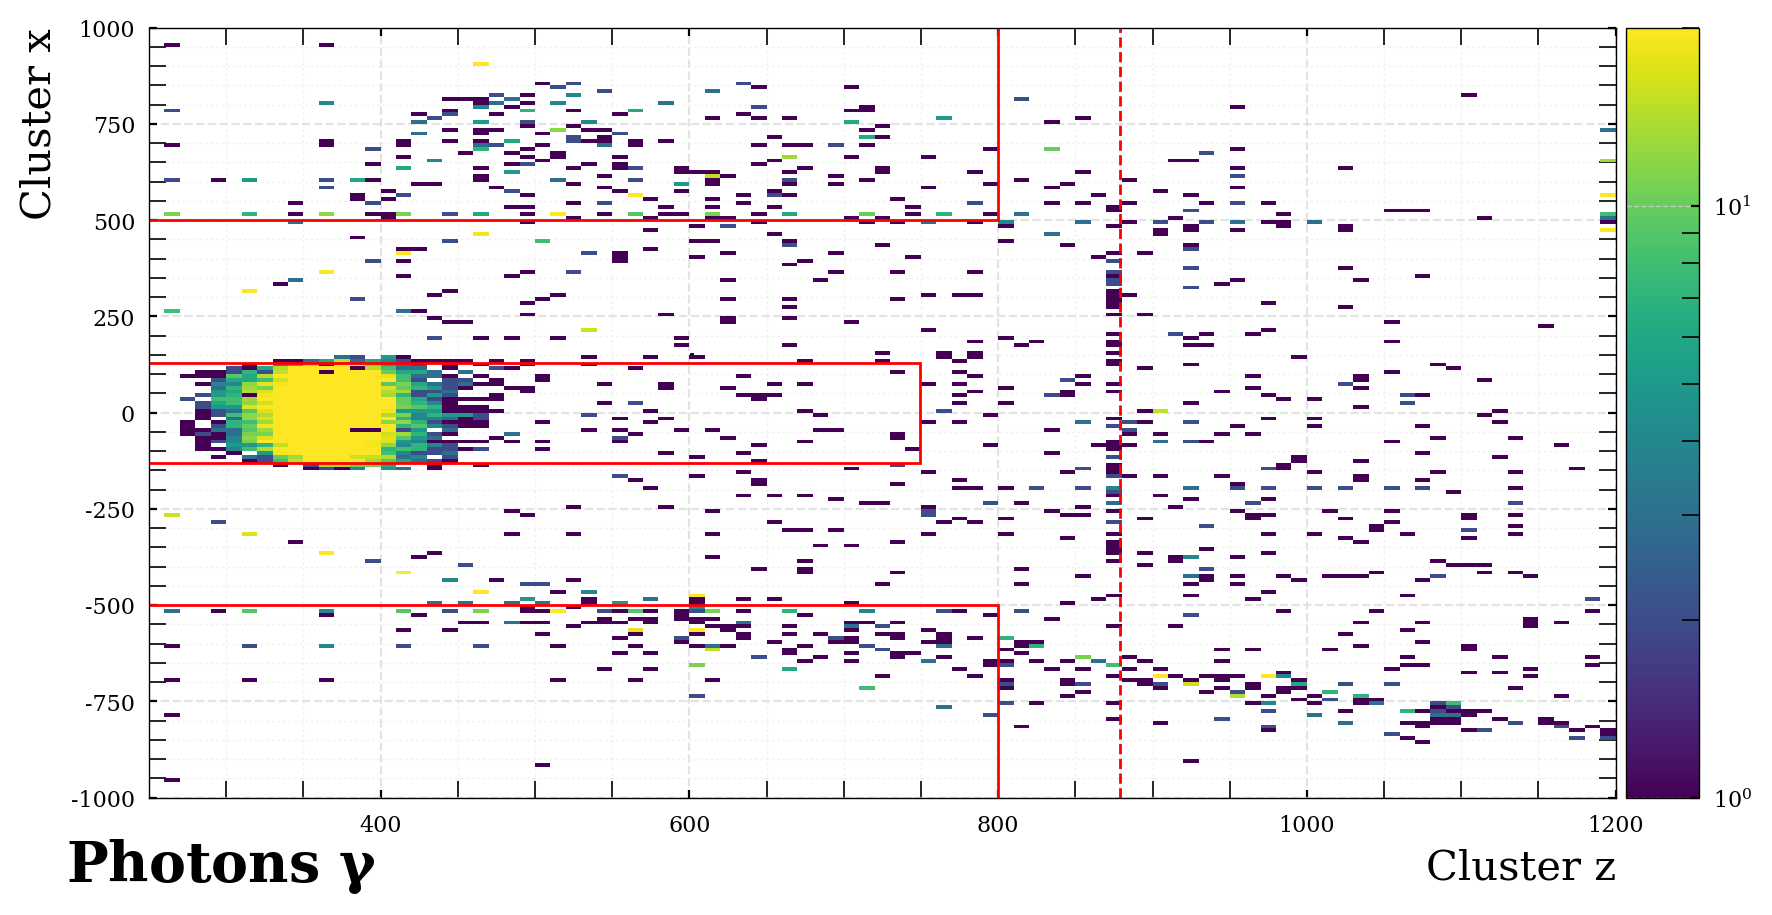

In [18]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
plotting.hist2d(fig, ax,
                photons.get('PFCandidates_ecalClusterZ'),
                photons.get('PFCandidates_ecalClusterX'),
                xlim=[250, 600],
                ylim=[-150, 150],
                xlabel='ECal cluster z',
                ylabel='ECal cluster x',
                binsize=10)
plotting.hist2d(fig, ax,
                photons.get('PFCandidates_hcalClusterZ'),
                photons.get('PFCandidates_hcalClusterX'),
                xlim=[250, 1200],
                ylim=[-1000, 1000],
                xlabel='Cluster z',
                ylabel='Cluster x',
                cbar_prop=None,
                binsize=10)
plot_ecal_box(ax)
plot_hcal_box(ax)
plt.legend(fontsize=15)
ax.annotate(text=labels_dict['photons'], xy=(-30, -30), xycoords='axes points', fontsize=20, weight='bold')
plt.show()

### Pions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Axes limits [250, 600] and [-150, 150]
Axes limits [250, 1200] and [-1000, 1000]


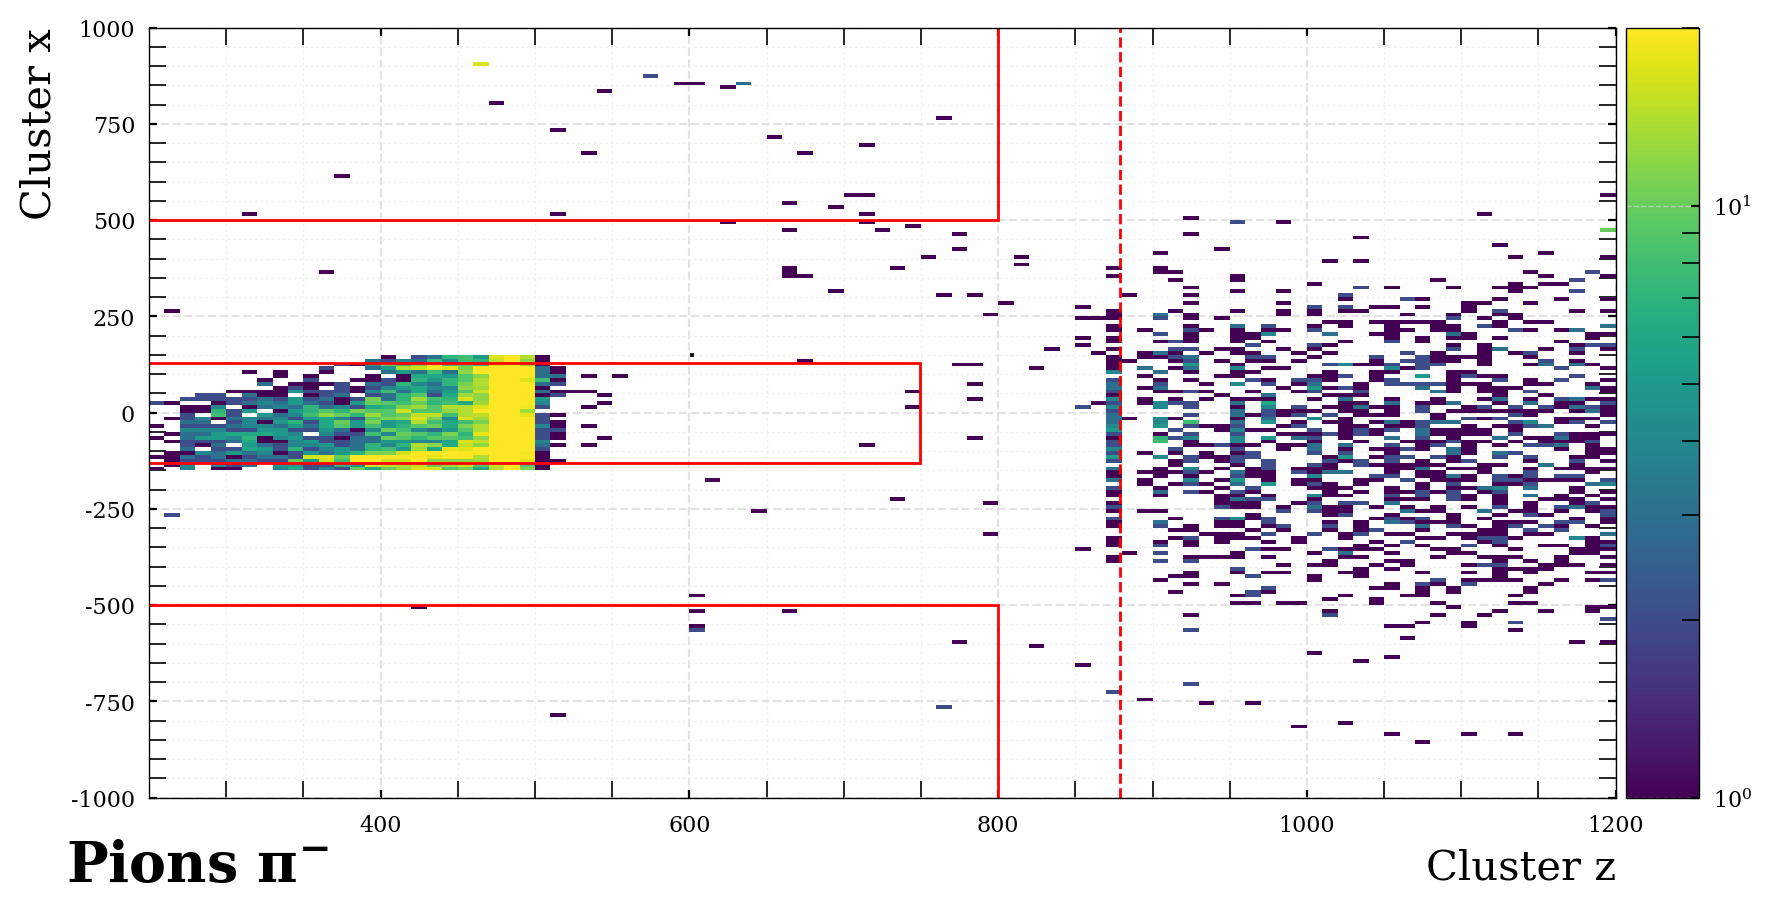

In [19]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
plotting.hist2d(fig, ax,
                pions.get('PFCandidates_ecalClusterZ'),
                pions.get('PFCandidates_ecalClusterX'),
                xlim=[250, 600],
                ylim=[-150, 150],
                xlabel='ECal cluster z',
                ylabel='ECal cluster x',
                binsize=10)
# plotting.scatter(fig, ax,
#                  pions.get('PFCandidates_ecalClusterZ'), pions.get('PFCandidates_ecalClusterX'),
#                  s = 15, lw = 0.5, c = 'blue', a = 0.8,
#                  xlim=[250, 500], ylim=[-1000, 1000],
#                  label='HCal',
#                  draw_line=False,
#                  xlabel='Cluster z', ylabel='Cluster x')
plotting.hist2d(fig, ax,
                pions.get('PFCandidates_hcalClusterZ'),
                pions.get('PFCandidates_hcalClusterX'),
                xlim=[250, 1200],
                ylim=[-1000, 1000],
                xlabel='Cluster z',
                ylabel='Cluster x',
                cbar_prop=None,
                binsize=10)
plot_ecal_box(ax)
plot_hcal_box(ax)
plt.legend(fontsize=15)
ax.annotate(text=labels_dict['pions'], xy=(-30, -30), xycoords='axes points', fontsize=20, weight='bold')
plt.show()

### Protons

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Axes limits [250, 600] and [-150, 150]
Axes limits [250, 1200] and [-1000, 1000]


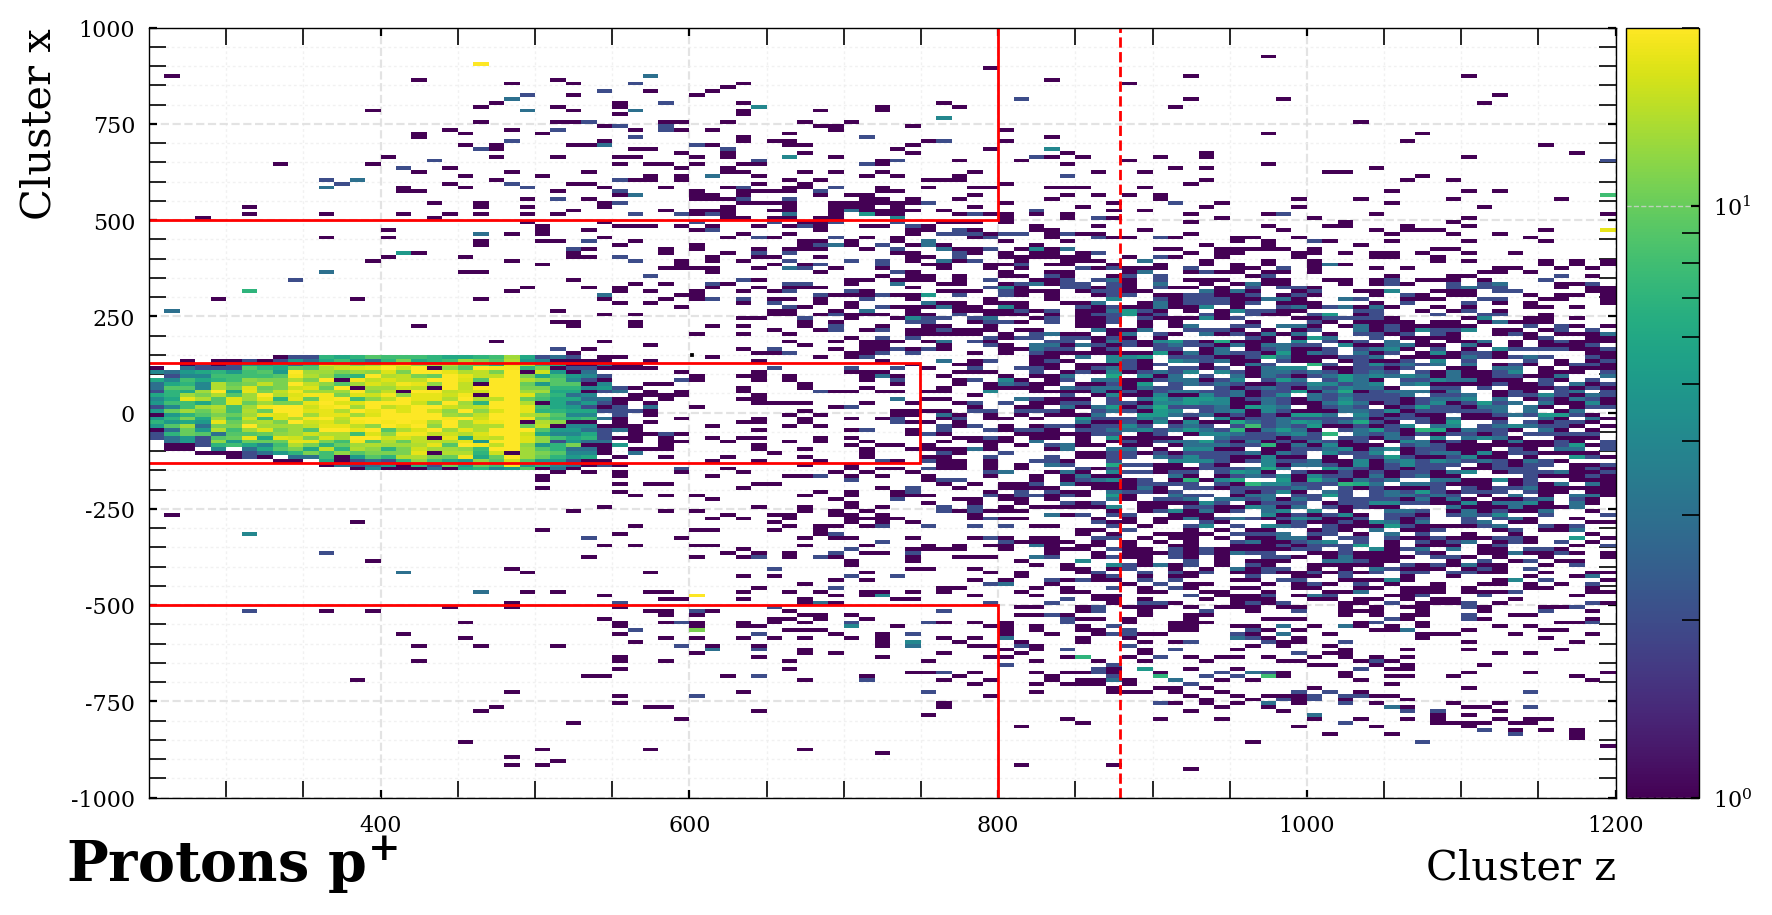

In [20]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
plotting.hist2d(fig, ax,
                protons.get('PFCandidates_ecalClusterZ'),
                protons.get('PFCandidates_ecalClusterX'),
                xlim=[250, 600],
                ylim=[-150, 150],
                xlabel='ECal cluster z',
                ylabel='ECal cluster x',
                binsize=10)
plotting.hist2d(fig, ax,
                protons.get('PFCandidates_hcalClusterZ'),
                protons.get('PFCandidates_hcalClusterX'),
                xlim=[250, 1200],
                ylim=[-1000, 1000],
                xlabel='Cluster z',
                ylabel='Cluster x',
                cbar_prop=None,
                binsize=10)
plot_ecal_box(ax)
plot_hcal_box(ax)
plt.legend(fontsize=15)
ax.annotate(text=labels_dict['protons'], xy=(-30, -30), xycoords='axes points', fontsize=20, weight='bold')
plt.show()

## Matching visualization

### Investigating angles

A script that shows:

* the angle at which the particle is shot into the recoil tracker: `PFCandidates_trackPx`/`PFCandidates_trackPz`
* the angle of the ecal cluster `ecal_clusterDXDZ`
* the angle of the hcal cluster `hcal_clusterDXDZ`

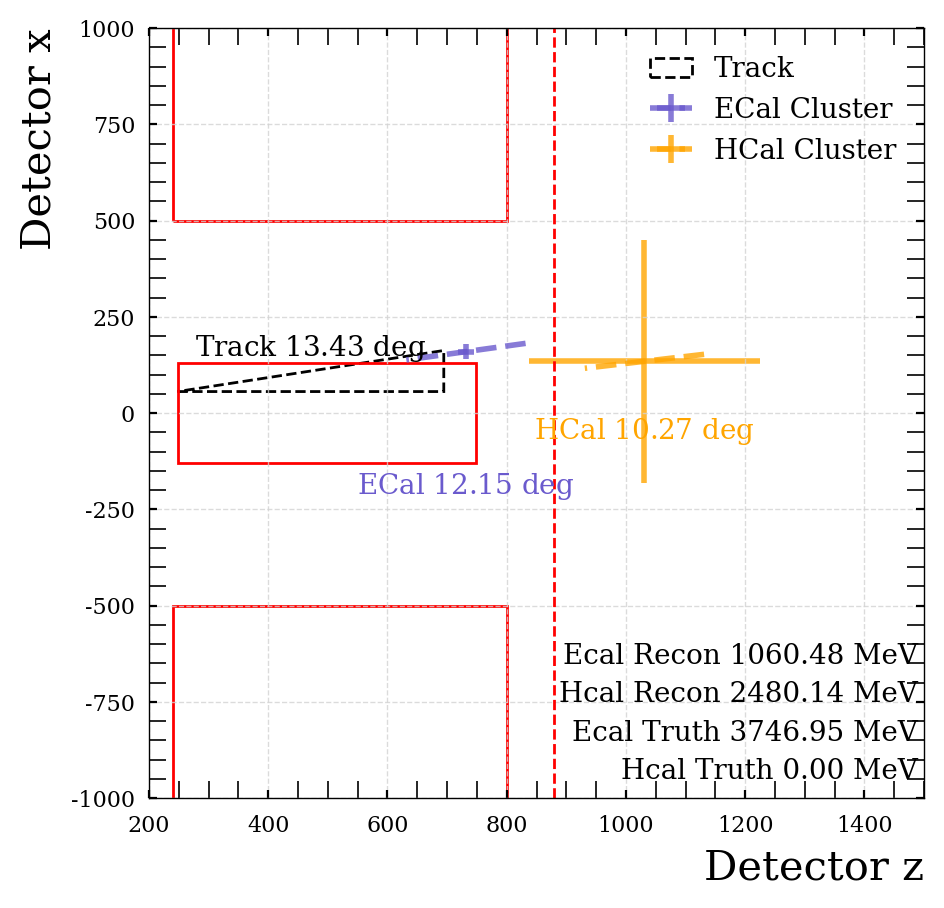

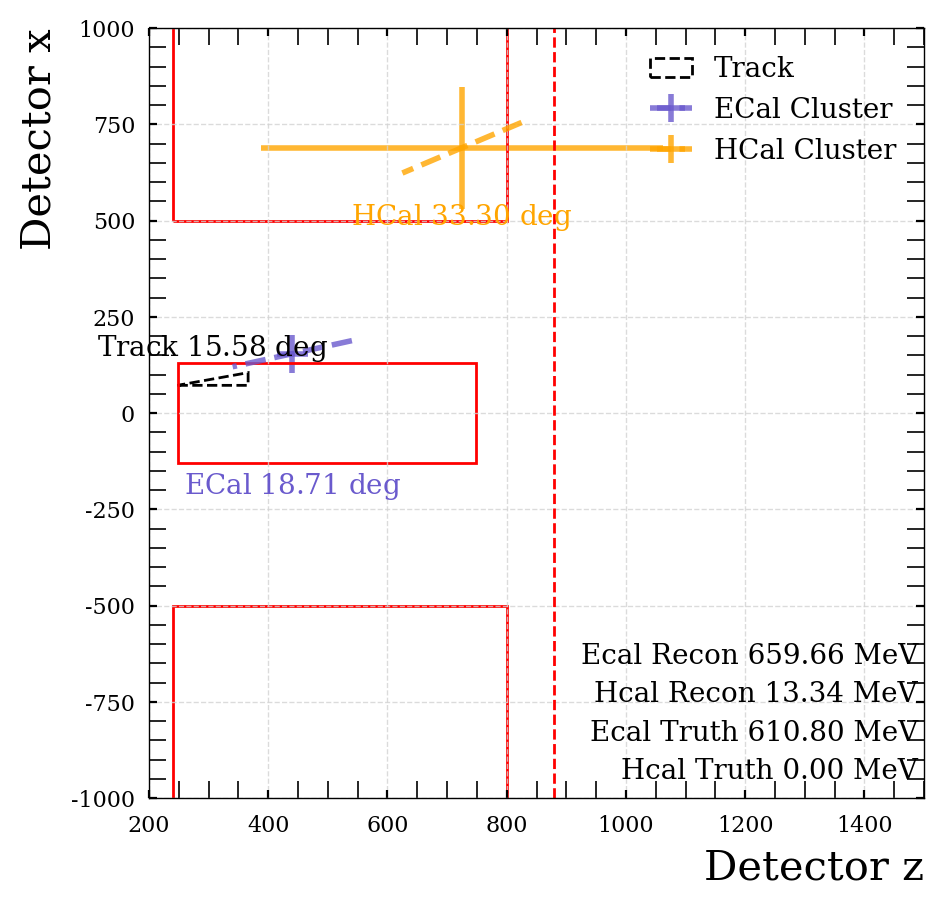

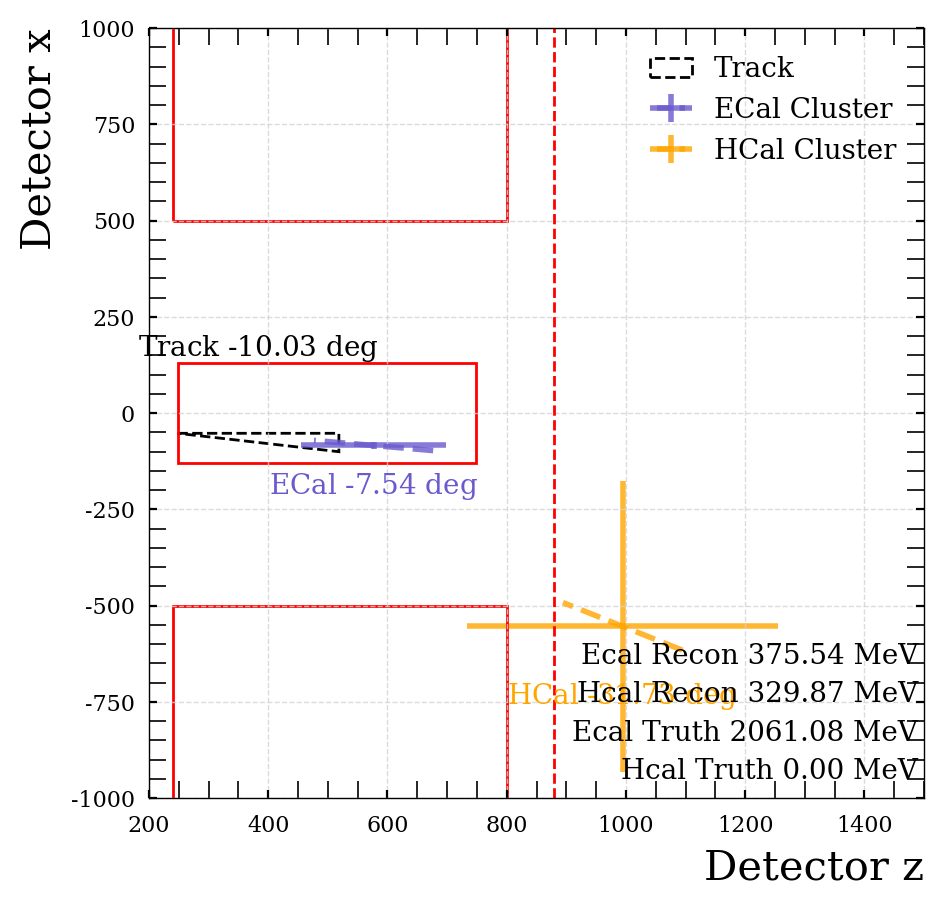

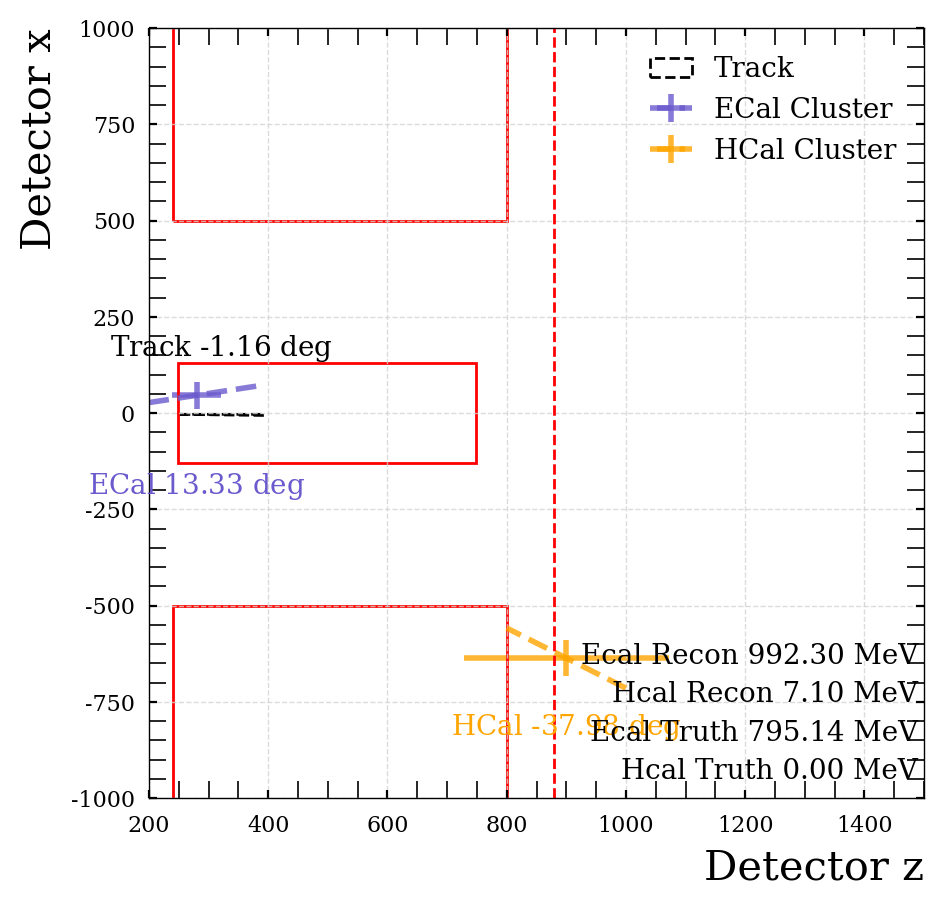

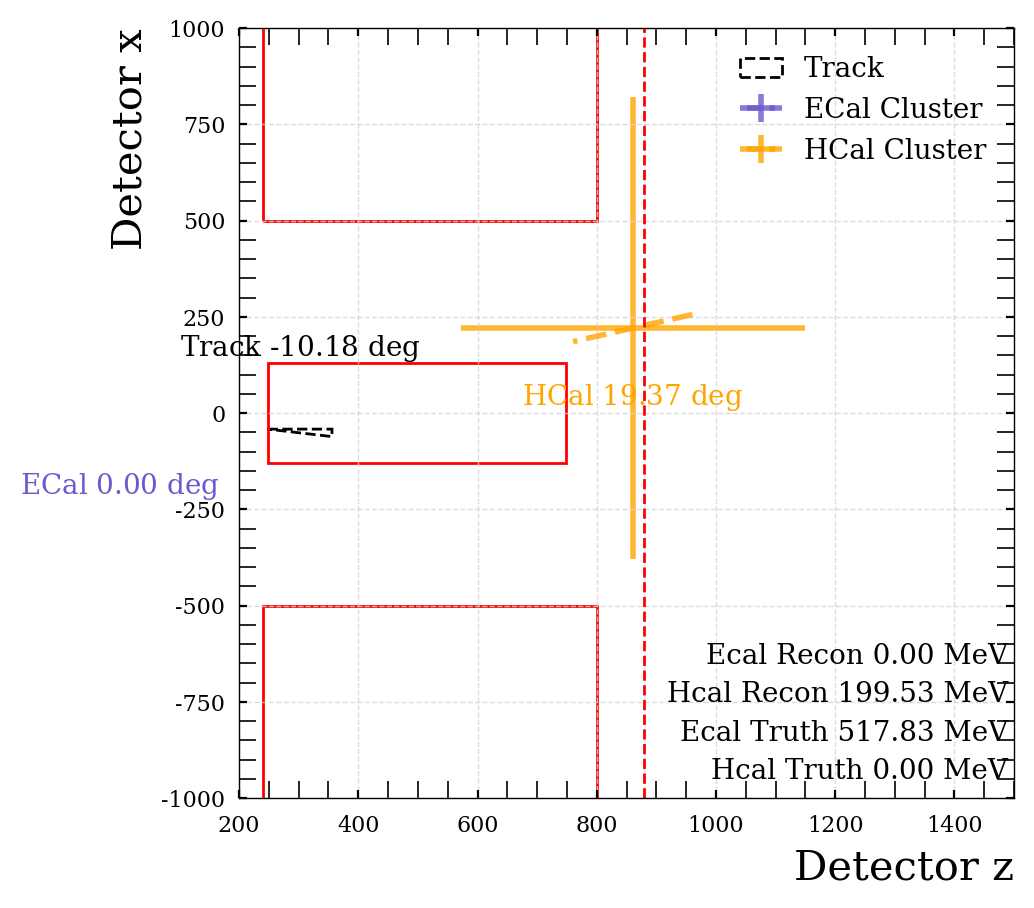

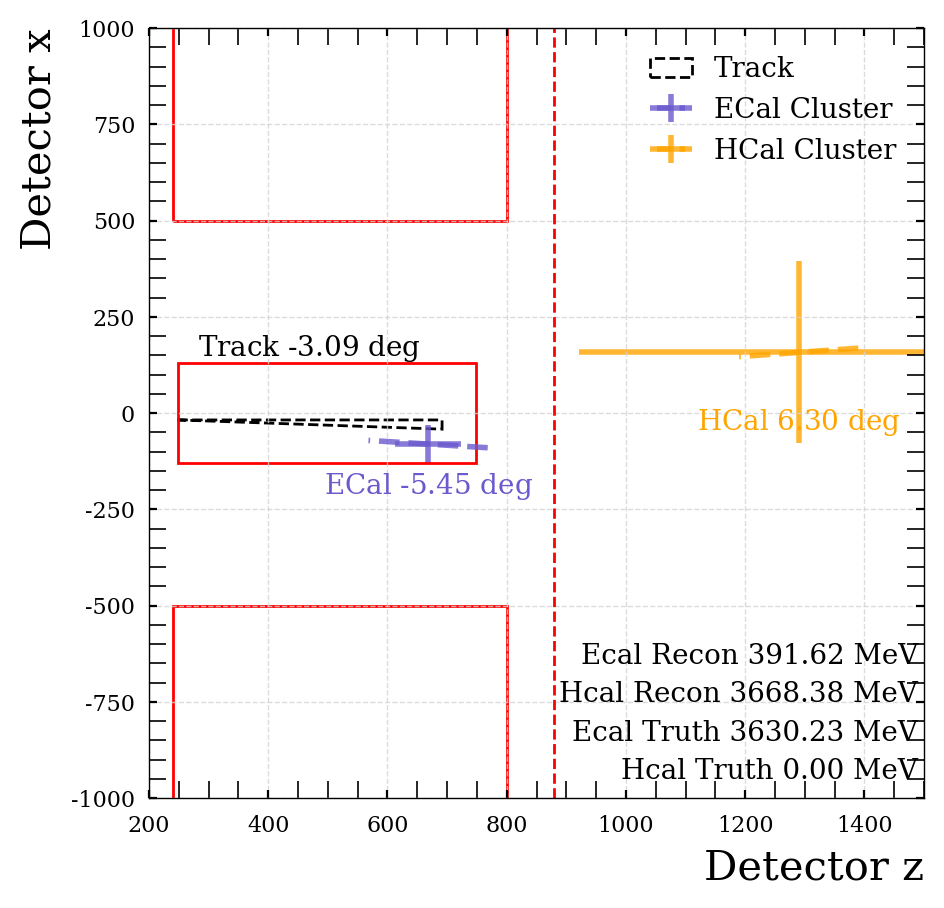

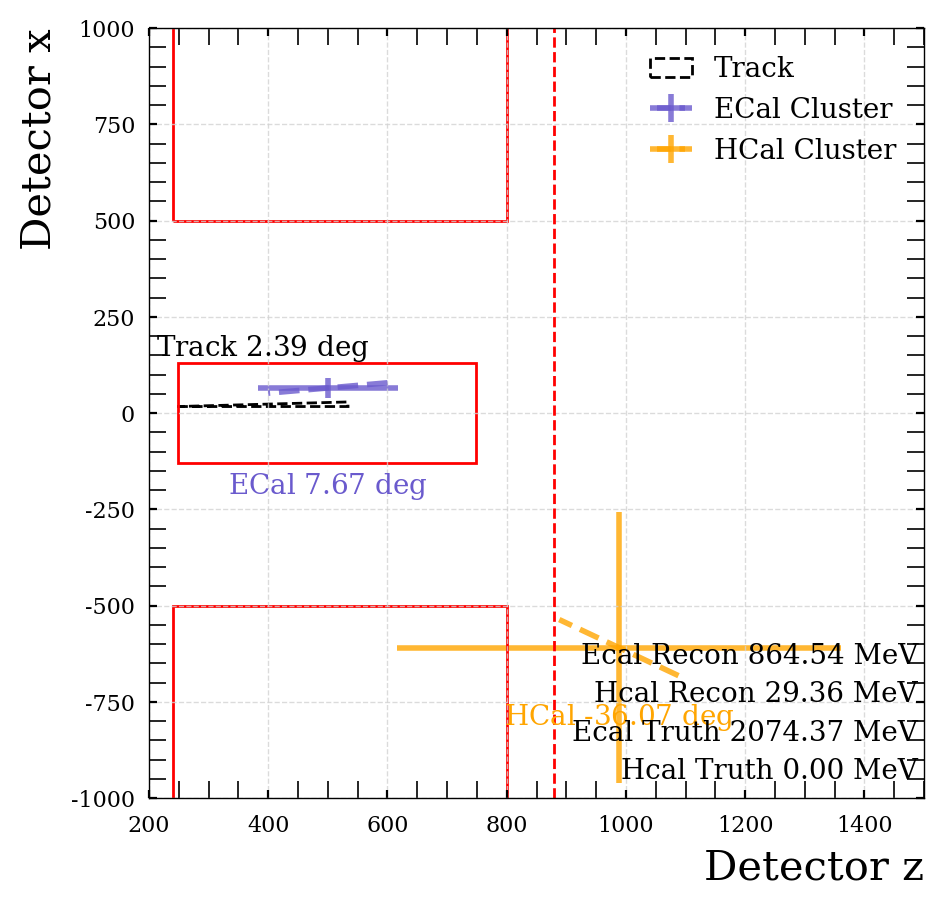

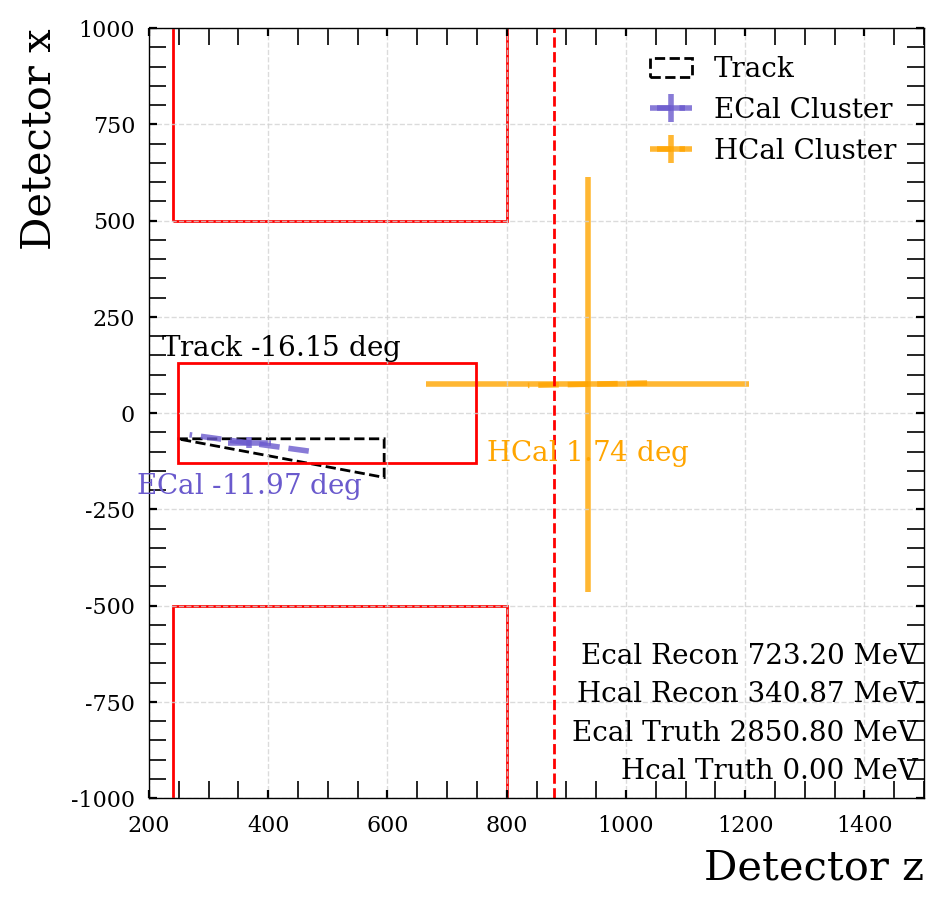

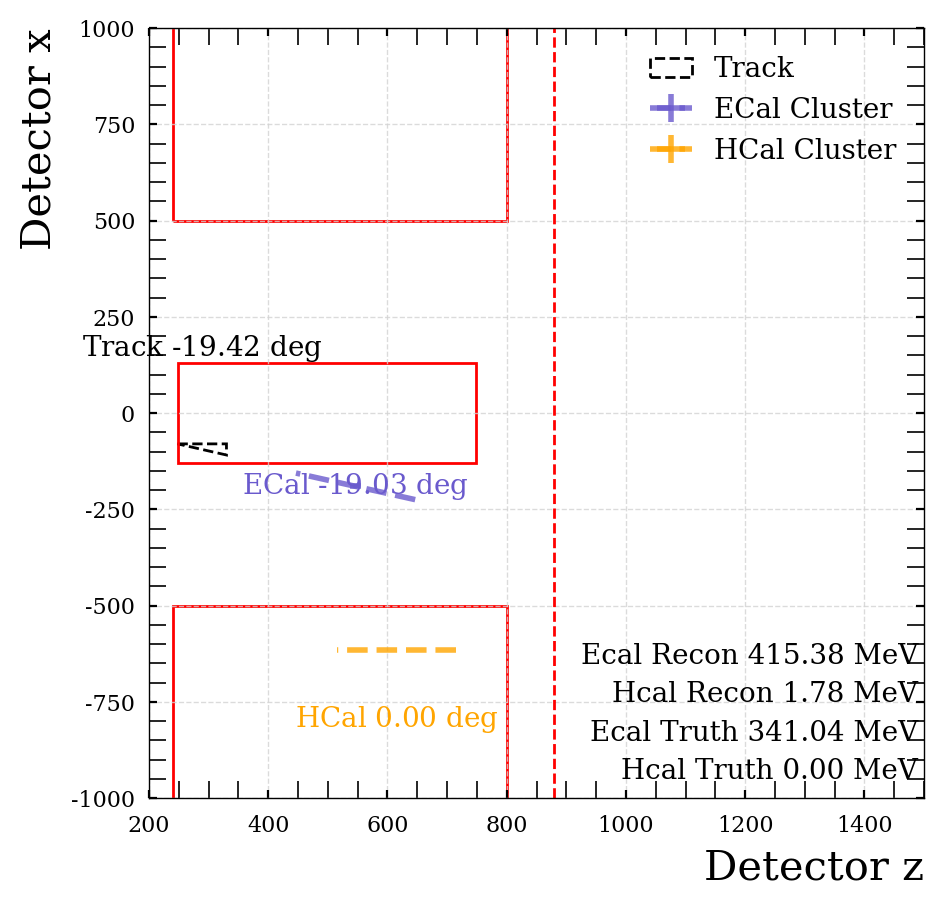

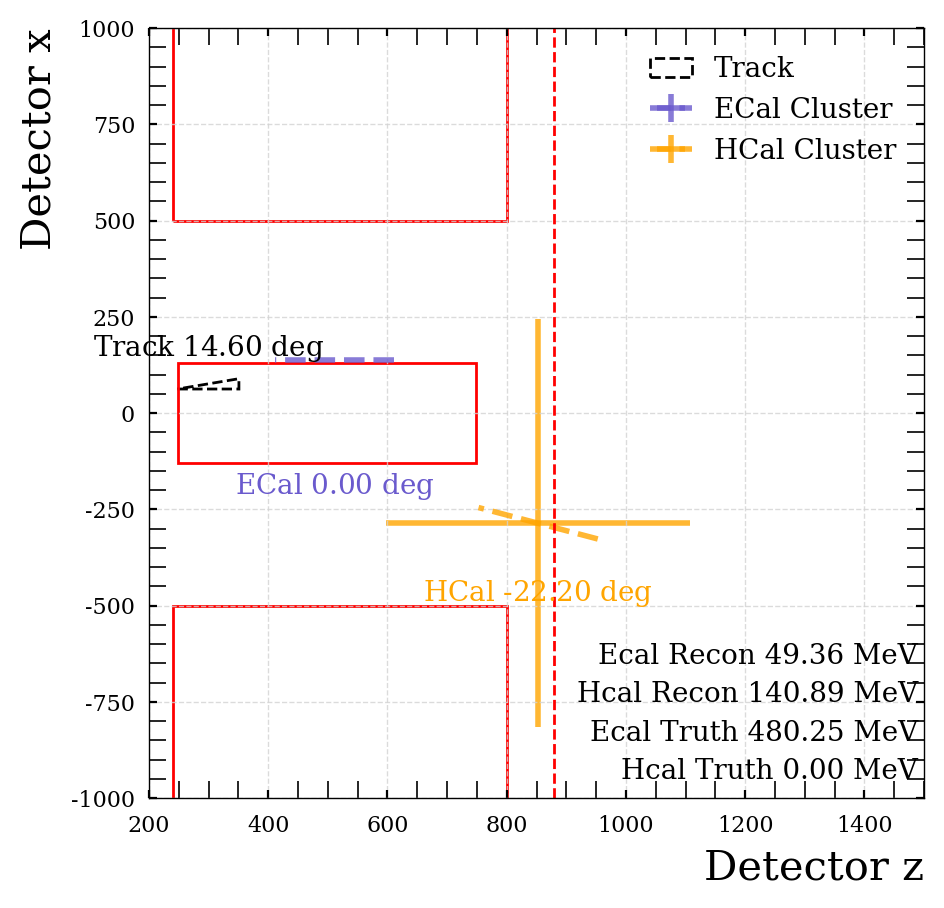

In [82]:
from matplotlib.patches import Polygon

def plot_cluster_dist(particles, i=0, factor=10, length=100, extend=False,
                      track_color = 'black', ecal_color = 'slateblue', hcal_color = 'orange'):
    track_Pz = particles.get('PFCandidates_trackPz')
    track_Px = particles.get('PFCandidates_trackPx')
    track_posX = particles.get('PFCandidates_posEcalX')
    ecal_clusterZ = particles.get('PFCandidates_ecalClusterZ')
    ecal_clusterX = particles.get('PFCandidates_ecalClusterX')
    ecal_clusterEZ = particles.get('PFCandidates_ecalClusterEZ')
    ecal_clusterEX = particles.get('PFCandidates_ecalClusterEX')
    ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDXDZ')
    hcal_clusterZ = particles.get('PFCandidates_hcalClusterZ')
    hcal_clusterX = particles.get('PFCandidates_hcalClusterX')
    hcal_clusterEZ = particles.get('PFCandidates_hcalClusterEZ')
    hcal_clusterEX = particles.get('PFCandidates_hcalClusterEX')
    hcal_clusterDXDZ = particles.get('PFCandidates_hcalClusterDXDZ')
    
    # setting up plot
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    
    """Track Momentum"""
    # add triangle
    Pz = track_Pz[i]/factor
    Px = track_Px[i]/factor
    xy = [[ECALZ_MIN, track_posX[i]], [ECALZ_MIN+Pz, track_posX[i]], [ECALZ_MIN+Pz, track_posX[i]+Px]]
    momentum = Polygon(xy=xy, fc='None', ec=track_color, ls='--', label='Track')
    ax.add_patch(momentum)
    # add annotation
    track_angle = np.rad2deg(np.arctan(Px/Pz))
    ax.text(ECALZ_MIN+Pz/2, ECALW/2+20, fr'Track {track_angle:.2f} $\deg$', color=track_color, ha='center')
    # extend
    if extend:
        ax.axline(xy1=[ECALZ_MIN, track_posX[i]], xy2=[ECALZ_MIN + Pz * 10, track_posX[i] + Px * 10], lw=1, ls='--', alpha=0.5, color=track_color)
    
    """Ecal Box"""
    ecal_z = ecal_clusterZ[i]
    ecal_x = ecal_clusterX[i]
    ecal_ez = ecal_clusterEZ[i]
    ecal_ex = ecal_clusterEX[i]
    plotting.error_bar(fig, ax, x=ecal_z, y=ecal_x, xerr=[[ecal_ez], [ecal_ez]], yerr=[[ecal_ex], [ecal_ex]], color=ecal_color, fmt='--', label='ECal Cluster')
    # the angle
    ecal_tan = ecal_clusterDXDZ[i]
    ecal_angle = np.rad2deg(np.arctan(ecal_tan))
    ax.plot([ecal_z+length, ecal_z-length], [ecal_x+length*ecal_tan, ecal_x-length*ecal_tan], color=ecal_color, ls='--', alpha=0.8)
    ax.text(ecal_z, -ECALW/2-80, fr'ECal {ecal_angle:.2f} $\deg$', color=ecal_color, ha='center')
    # extend
    if extend:
        ax.axline(xy1=[ecal_z, ecal_x], xy2=[ecal_z + length * 10, ecal_x + length * 10 * ecal_tan], lw=1, ls='--', alpha=0.5, color=ecal_color)
    
    """Hcal Box"""
    hcal_z = hcal_clusterZ[i]
    hcal_x = hcal_clusterX[i]
    hcal_ez = hcal_clusterEZ[i]
    hcal_ex = hcal_clusterEX[i]
    plotting.error_bar(fig, ax, x=hcal_z, y=hcal_x, xerr=[[hcal_ez], [hcal_ez]], yerr=[[hcal_ex], [hcal_ex]], color=hcal_color, fmt='--', label='HCal Cluster')
    # the angle
    hcal_tan = hcal_clusterDXDZ[i]
    hcal_angle = np.rad2deg(np.arctan(hcal_tan))
    ax.plot([hcal_z+length, hcal_z-length], [hcal_x+length*hcal_tan, hcal_x-length*hcal_tan], color=hcal_color, ls='--', alpha=0.8)
    ax.text(hcal_z, hcal_x-length*2, fr'HCal {hcal_angle:.2f} $\deg$', color=hcal_color, ha='center')
    # extend
    if extend:
        ax.axline(xy1=[hcal_z, hcal_x], xy2=[hcal_z + length * 10, hcal_x + length * 10 * hcal_tan], lw=1, ls='--', alpha=0.5, color=hcal_color)
    
    # axis
    ax.set_xlabel('Detector z')
    ax.set_ylabel('Detector x')
    ax.set_xlim(200, 1500)
    ax.set_ylim(-1000, 1000)

    # particle and energy
    measure_ecal_energy = particles.get("PFCandidates_ecalEnergy")[i]
    measure_hcal_energy = particles.get("PFCandidates_hcalEnergy")[i]
    recon_ecal_energy = particles.get("PFCandidates_ecalEnergy_o1corr")[i]
    recon_hcal_energy = particles.get("PFCandidates_hcalEnergy_o1corr")[i]
    truth_ecal_energy = particles.get("PFTruthEcal_energy")[i]
    truth_hcal_energy = particles.get("PFTruthHcal_energy")[i]
    energy_text_x = 1490
    # ax.text(energy_text_x, -450, f'Ecal {measure_ecal_energy:.2f} MeV', ha='right')
    # ax.text(energy_text_x, -550, f'Hcal {measure_hcal_energy:.2f} MeV', ha='right')
    ax.text(energy_text_x, -650, f'Ecal Recon {recon_ecal_energy:.2f} MeV', ha='right')
    ax.text(energy_text_x, -750, f'Hcal Recon {recon_hcal_energy:.2f} MeV', ha='right')
    ax.text(energy_text_x, -850, f'Ecal Truth {truth_ecal_energy:.2f} MeV', ha='right')
    ax.text(energy_text_x, -950, f'Hcal Truth {truth_hcal_energy:.2f} MeV', ha='right')
    
    # boxes
    plot_ecal_box(ax, 0)
    plot_hcal_box(ax, 0)
    plt.legend(fontsize=10)
    plt.show()

for i in range(10):
    plot_cluster_dist(neutrons, i)

# Investigating ECal rms

In [22]:
def plot_ecal_residual_dist(particles, xy='x', erg_min=0, erg_max=5, plot_bool=[1, 1, 1], fig=None, ax=None):

    """Mask"""
    mask = np.logical_and(particles.get('PFCandidates_ecalEnergy_o1corr')/1e3 >= erg_min,
                          particles.get('PFCandidates_ecalEnergy_o1corr')/1e3 <= erg_max)
    if not fig or not ax:
        fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
    
    """Switch"""
    if xy in ['y', 'Y']:
        track_Px = particles.get('PFCandidates_trackPy')[mask]
        track_posX = particles.get('PFCandidates_posEcalY')[mask]
        ecal_clusterX = particles.get('PFCandidates_ecalClusterY')[mask]
        ecal_clusterEX = particles.get('PFCandidates_ecalClusterEY')[mask]
        ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDYDZ')[mask]
    else:
        track_Px = particles.get('PFCandidates_trackPx')[mask]
        track_posX = particles.get('PFCandidates_posEcalX')[mask]
        ecal_clusterX = particles.get('PFCandidates_ecalClusterX')[mask]
        ecal_clusterEX = particles.get('PFCandidates_ecalClusterEX')[mask]
        ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDXDZ')[mask]
    track_Pz = particles.get('PFCandidates_trackPz')[mask]
    ecal_clusterZ = particles.get('PFCandidates_ecalClusterZ')[mask]
    ecal_clusterEZ = particles.get('PFCandidates_ecalClusterEZ')[mask]
    
    # setting up plot
    """Ecal Box"""
    if plot_bool[0]:
        # ecal hits distribution
        plotting.hist2d(fig, ax,
                        ecal_clusterZ,
                        ecal_clusterX,
                        xlim=[250, 600],
                        ylim=[-150, 150],
                        xlabel='ECal cluster z',
                        ylabel='ECal cluster y' if xy in ['y', 'Y'] else 'ECal cluster x',
                        binsize=10)
        # track x distribution
        ax.hist(track_posX, orientation='horizontal', alpha=0.5)
        # axis
        ax.set_xlabel('Detector z')
        ax.set_ylabel('Detector x')
        ax.set_xlim(200, 1500)
        ax.set_ylim(-1000, 1000)
        # boxes
        plot_ecal_box(ax, 0)
        plot_hcal_box(ax, 0)
        ax.legend(fontsize=10)
        fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
    
    
    """The distributions"""
    # track angle
    track_tan = track_Px/track_Pz
    track_angle = np.rad2deg(np.arctan(track_tan))
    
    # ecal angle
    ecal_tan = ecal_clusterDXDZ
    ecal_angle = np.rad2deg(np.arctan(ecal_tan))
    
    if plot_bool[1]:
        # make the plot
        plotting.hist(fig, ax, [track_angle, ecal_angle], labels=['track', 'ecal'], nbins=20, draw_median=True, draw_quartiles=True)
        ax.legend(fontsize=10)
        ax.set_xlabel(fr'Angle in {xy} [$\circ$]')
        ax.set_xlim([-80, 80])
        plt.show()
        fig, ax = plt.subplots(figsize=(5, 3), dpi=200)

    """RMS plot"""
    if plot_bool[2]:
        # distance to project
        proj_distZ = ecal_clusterZ - ECALZ_MIN
        proj_distX = proj_distZ * track_tan
        proj_ecalX = track_posX + proj_distX  # the projected x position on ecal plane
        proj_EX = ecal_clusterX - proj_ecalX  # difference between projected and cluster position
        proj_rms = proj_EX/ecal_clusterEX
    
        # make the plot
        proj_rms = proj_rms[~np.isinf(proj_rms)]
        plotting.hist(fig, ax, [proj_rms], labels=['bruh'], binwidth=0.5, draw_median=True, draw_quartiles=True)
        ax.set_yscale('log')
        ax.set_xlim(-10, 10)
        ax.set_xlabel(r'$\times$ ecal error')

    return track_angle, ecal_angle

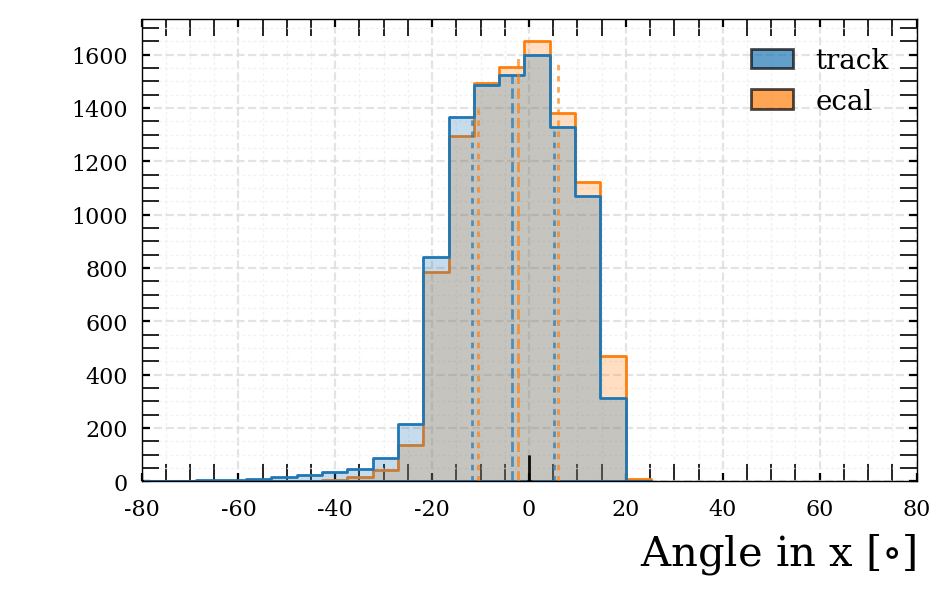

(array([  4.822108 , -19.76345  ,   9.456541 , ..., -14.284707 ,
         -5.3812118,  -4.544364 ], dtype=float32),
 array([  6.501689 , -20.29587  ,   9.347285 , ..., -15.94521  ,
         -4.374803 ,  -3.8906462], dtype=float32))

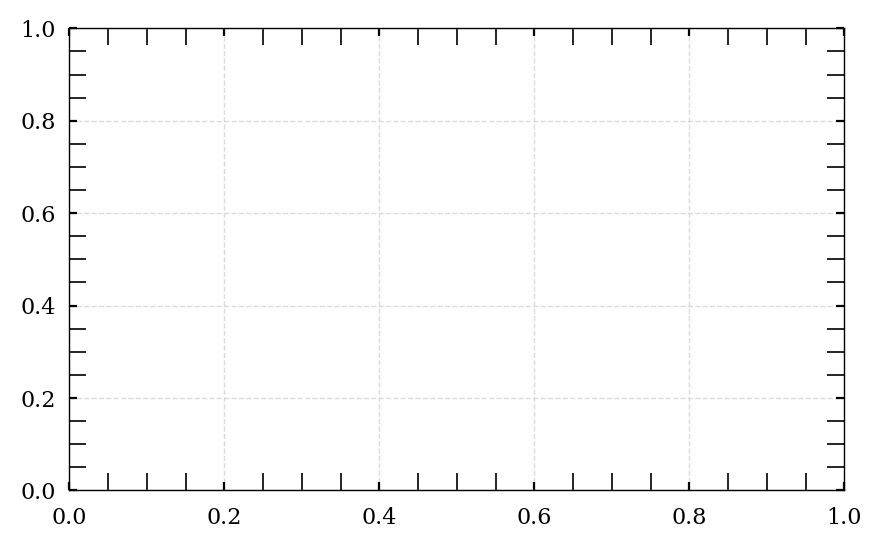

In [23]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
plot_ecal_residual_dist(electrons, 'x', 0, 4, [0, 1, 0], fig, ax)

## ECal Resolution

In [76]:
def plot_clust_resolution_ecal(fig, ax, particles_name, xy='x', marker='+', color='slateblue', binwidth=200, size=50, erg_max=5e3, alpha=1, label=True):
    plotting.style_ldmx(fig, ax)
    import scipy.stats as stats

    """Grab the Numbers"""
    particles = both_particles_dict[particles_name]
    # set the reconstructed energy
    erg_recon = particles.get('PFCandidates_ecalEnergy_o1corr')
    # ratio of cluster resolution
    """Switch"""
    if xy in ['y', 'Y']:
        track_Px = particles.get('PFCandidates_trackPy')
        track_posX = particles.get('PFCandidates_posEcalY')
        ecal_clusterX = particles.get('PFCandidates_ecalClusterY')
        ecal_clusterEX = particles.get('PFCandidates_ecalClusterEY')
        ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDYDZ')
    else:
        track_Px = particles.get('PFCandidates_trackPx')
        track_posX = particles.get('PFCandidates_posEcalX')
        ecal_clusterX = particles.get('PFCandidates_ecalClusterX')
        ecal_clusterEX = particles.get('PFCandidates_ecalClusterEX')
        ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDXDZ')
    ecal_clusterZ = particles.get('PFCandidates_ecalClusterZ')
    track_Pz = particles.get('PFCandidates_trackPz')
    ecal_clusterZ = particles.get('PFCandidates_ecalClusterZ')
    ecal_clusterEZ = particles.get('PFCandidates_ecalClusterEZ')

    # track angle
    track_tan = track_Px/track_Pz
    track_angle = np.rad2deg(np.arctan(track_tan))
    
    # ecal angle
    ecal_tan = ecal_clusterDXDZ
    ecal_angle = np.rad2deg(np.arctan(ecal_tan))
    proj_distZ = ecal_clusterZ - ECALZ_MIN
    proj_distX = proj_distZ * track_tan
    proj_ecalX = track_posX + proj_distX  # the projected x position on ecal plane
    proj_EX = ecal_clusterX - proj_ecalX  # difference between projected and cluster position
    # the number for each bin
    proj_rms = proj_EX/ecal_clusterEX

    """Bin"""
    # filter outliers
    proj_rms, erg_recon = plotting._clean_data(proj_rms, erg_recon)

    X = erg_recon
    Y = proj_rms
    # get bins
    XY_bins = np.arange(start=0, stop=erg_max, step=binwidth) # bins, including last element
    XY_bins = np.append(XY_bins, XY_bins[-1] + binwidth)
    
    # define percentile functions
    def _16(arr): return np.quantile(arr, .159) # sigma CI
    def _84(arr): return np.quantile(arr, .841)
    def _05(arr): return np.quantile(arr, .025) # 95%, close to 2 sigma CI
    def _95(arr): return np.quantile(arr, .975)
    XY_med = stats.binned_statistic(X, Y, statistic=np.median, bins=XY_bins)[0] # median
    XY_16 = stats.binned_statistic(X, Y, statistic=_16, bins=XY_bins)[0] # percentiles
    XY_84 = stats.binned_statistic(X, Y, statistic=_84, bins=XY_bins)[0]
    XY_05 = stats.binned_statistic(X, Y, statistic=_05, bins=XY_bins)[0]
    XY_95 = stats.binned_statistic(X, Y, statistic=_95, bins=XY_bins)[0]
    XY_bins_avg = [(a + b) / 2 for a, b in zip(XY_bins[::], XY_bins[1::])] # average of two consecutive elements in bins

    part_label = label
    plotting.scatter(fig, ax, XY_bins_avg, (XY_84 - XY_16)/2, s=40, lw=2, c=color, a=alpha, label=part_label, xlabel='ECal Energy Bins', ylabel=r'Projection / Cluster $\sigma$')

full_particles_list = [
    'electrons',
    'photons',
    'neutrons',
    'pions',
    'protons'
]

def plot_clust_resolution_ecal_others(fig, ax, particles_list, binwidth=200, erg_max=5e3):
    other_particles_list = []
    for particles in full_particles_list:
        # add every particle not in the list to plot
        if particles not in particles_list:
            other_particles_list.append(particles)
    
    # all other particles
    plot_clust_resolution_ecal(fig, ax, other_particles_list[0], binwidth=binwidth, erg_max=5e3, color='gray', alpha=0.3, label='Others')
    for particles in other_particles_list[1:]:
        plot_clust_resolution_ecal(fig, ax, particles, binwidth=binwidth, erg_max=5e3, color='gray', alpha=0.3, label=None)

In [57]:
binwidth = 200

### Electrons

Axes limits [100.0, 3900.0] and [0.12465027250349521, 0.461157101020217]
Axes limits [100.0, 3900.0] and [0.14207620810717345, 0.7068962008059025]
Axes limits [100.0, 4900.0] and [0.0, 1.668863470673561]
Axes limits [100.0, 4500.0] and [0.0, 0.7689638481736183]
Axes limits [100.0, 4700.0] and [0.0, 0.5191318480074406]


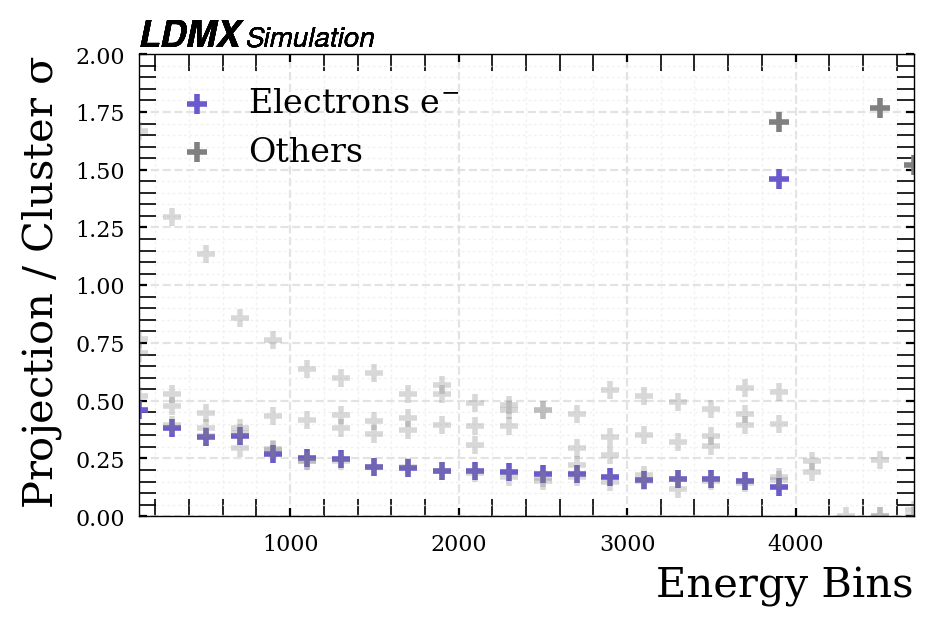

In [58]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['electrons']
plot_clust_resolution_ecal(fig, ax, 'electrons', binwidth=binwidth, erg_max=5e3, label=labels_dict['electrons'])
plot_clust_resolution_ecal_others(fig, ax, part_particles_list, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 2)
ax.legend(fontsize=12)
plt.show()

### Photons

Axes limits [100.0, 3900.0] and [0.14207620810717345, 0.7068962008059025]
Axes limits [100.0, 3900.0] and [0.12465027250349521, 0.461157101020217]
Axes limits [100.0, 4900.0] and [0.0, 1.668863470673561]
Axes limits [100.0, 4500.0] and [0.0, 0.7689638481736183]
Axes limits [100.0, 4700.0] and [0.0, 0.5191318480074406]


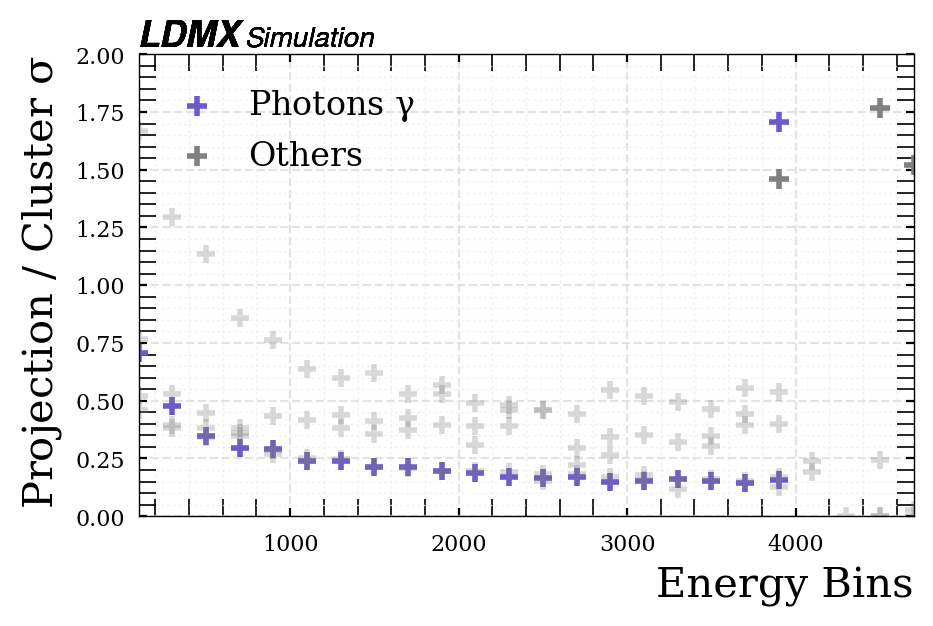

In [60]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['photons']
plot_clust_resolution_ecal(fig, ax, 'photons', binwidth=binwidth, erg_max=5e3, label=labels_dict['photons'])
plot_clust_resolution_ecal_others(fig, ax, part_particles_list, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 2)
ax.legend(fontsize=12)
plt.show()

### Pions

Axes limits [100.0, 4500.0] and [0.0, 0.7689638481736183]
Axes limits [100.0, 3900.0] and [0.12465027250349521, 0.461157101020217]
Axes limits [100.0, 3900.0] and [0.14207620810717345, 0.7068962008059025]
Axes limits [100.0, 4900.0] and [0.0, 1.668863470673561]
Axes limits [100.0, 4700.0] and [0.0, 0.5191318480074406]


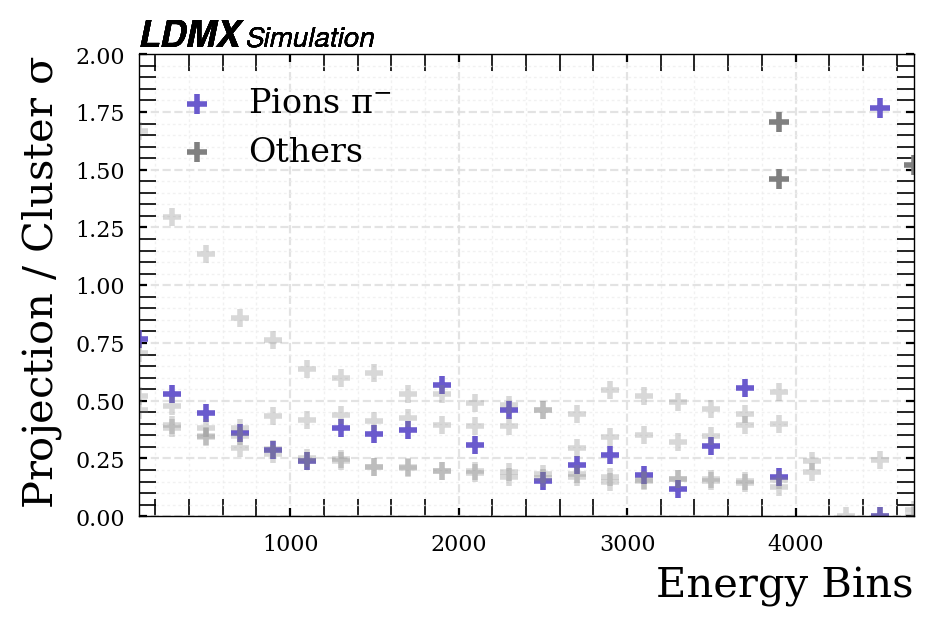

In [61]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['pions']
plot_clust_resolution_ecal(fig, ax, 'pions', binwidth=binwidth, erg_max=5e3, label=labels_dict['pions'])
plot_clust_resolution_ecal_others(fig, ax, part_particles_list, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 2)
ax.legend(fontsize=12)
plt.show()

### Protons

Axes limits [100.0, 4700.0] and [0.0, 0.5191318480074406]
Axes limits [100.0, 3900.0] and [0.12465027250349521, 0.461157101020217]
Axes limits [100.0, 3900.0] and [0.14207620810717345, 0.7068962008059025]
Axes limits [100.0, 4900.0] and [0.0, 1.668863470673561]
Axes limits [100.0, 4500.0] and [0.0, 0.7689638481736183]


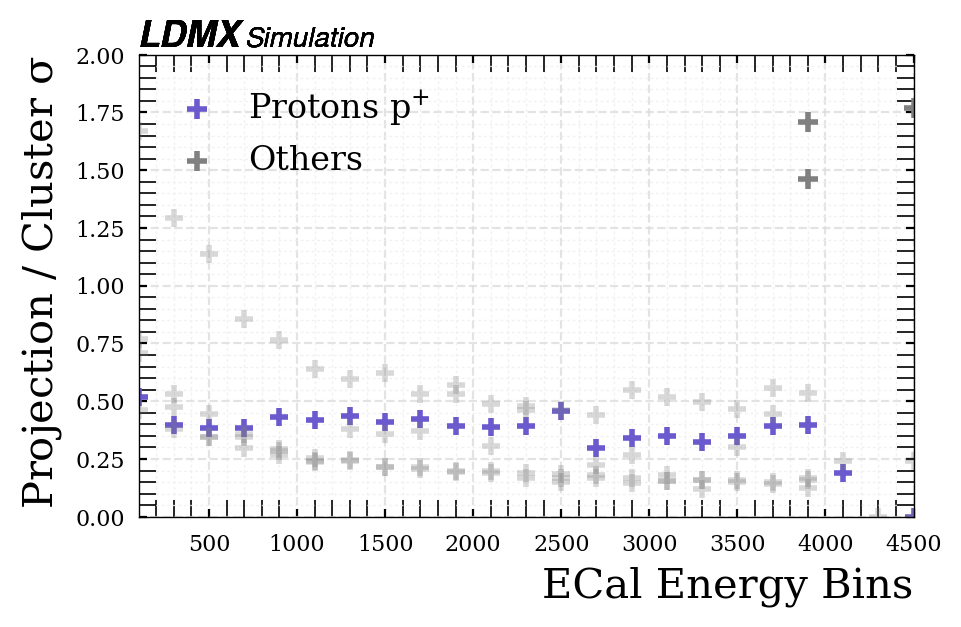

In [77]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['protons']
plot_clust_resolution_ecal(fig, ax, 'protons', binwidth=binwidth, erg_max=5e3, label=labels_dict['protons'])
plot_clust_resolution_ecal_others(fig, ax, part_particles_list, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 2)
ax.legend(fontsize=12)
plt.show()

### Neutrons

Axes limits [100.0, 4900.0] and [0.0, 1.668863470673561]
Axes limits [100.0, 3900.0] and [0.12465027250349521, 0.461157101020217]
Axes limits [100.0, 3900.0] and [0.14207620810717345, 0.7068962008059025]
Axes limits [100.0, 4500.0] and [0.0, 0.7689638481736183]
Axes limits [100.0, 4700.0] and [0.0, 0.5191318480074406]


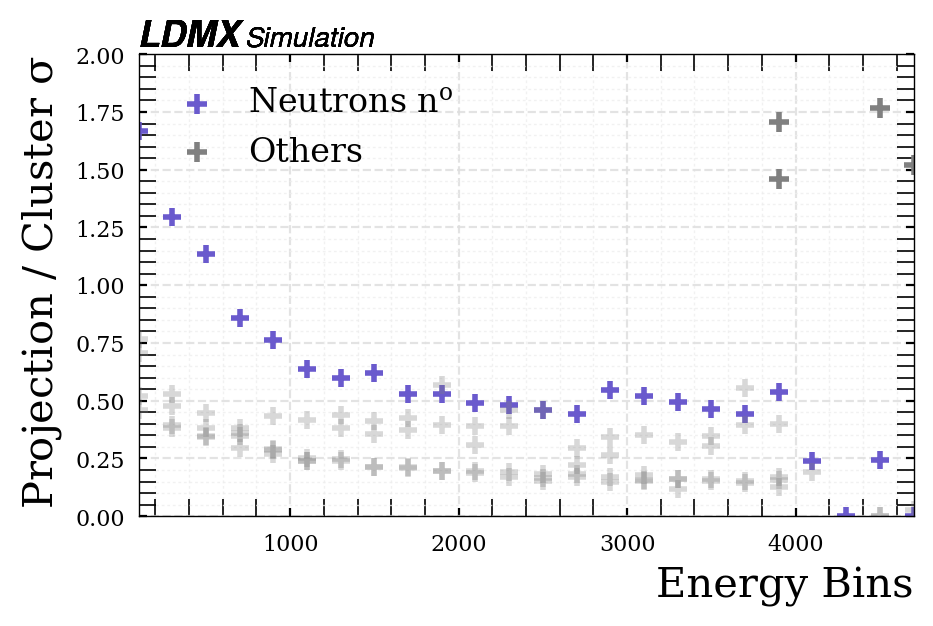

In [63]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['neutrons']
plot_clust_resolution_ecal(fig, ax, 'neutrons', binwidth=binwidth, erg_max=5e3, label=labels_dict['neutrons'])
plot_clust_resolution_ecal_others(fig, ax, part_particles_list, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 2)
ax.legend(fontsize=12)
plt.show()

# Investigating HCal rms

## HCal Resolution

In [68]:
def plot_clust_resolution_hcal(fig, ax, particles_name, xy='x', marker='+', color='slateblue', binwidth=200, size=50, erg_max=5e3, alpha=1, label=True):
    plotting.style_ldmx(fig, ax)
    import scipy.stats as stats

    """Grab the Numbers"""
    particles = both_particles_dict[particles_name]
    # set the reconstructed energy
    erg_recon = particles.get('PFCandidates_hcalEnergy_o1corr')
    # ratio of cluster resolution
    """Switch"""
    if xy in ['y', 'Y']:
        track_Px = particles.get('PFCandidates_trackPy') 
        track_posX = particles.get('PFCandidates_posEcalY')
        ecal_clusterX = particles.get('PFCandidates_ecalClusterY')
        ecal_clusterEX = particles.get('PFCandidates_ecalClusterEY')
        ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDYDZ')
        hcal_clusterX = particles.get('PFCandidates_hcalClusterY')
        hcal_clusterEX = particles.get('PFCandidates_hcalClusterEY')
        hcal_clusterDXDZ = particles.get('PFCandidates_hcalClusterDYDZ')
    else:
        track_Px = particles.get('PFCandidates_trackPx')
        track_posX = particles.get('PFCandidates_posEcalX')
        ecal_clusterX = particles.get('PFCandidates_ecalClusterX')
        ecal_clusterEX = particles.get('PFCandidates_ecalClusterEX')
        ecal_clusterDXDZ = particles.get('PFCandidates_ecalClusterDXDZ')
        hcal_clusterX = particles.get('PFCandidates_hcalClusterX')
        hcal_clusterEX = particles.get('PFCandidates_hcalClusterEX')
        hcal_clusterDXDZ = particles.get('PFCandidates_hcalClusterDXDZ')
    track_Pz = particles.get('PFCandidates_trackPz')
    ecal_clusterZ = particles.get('PFCandidates_ecalClusterZ')
    # ecal_clusterEZ = particles.get('PFCandidates_ecalClusterEZ')
    hcal_clusterZ = particles.get('PFCandidates_hcalClusterZ')
    # hcal_clusterEZ = particles.get('PFCandidates_hcalClusterEZ')

    # track angle
    track_tan = track_Px/track_Pz
    # ecal angle
    ecal_tan = ecal_clusterDXDZ
    # average angle
    avg_tan = np.mean([track_tan, ecal_tan], axis=0)

    # hcal angle
    # hcal_tan = hcal_clusterDXDZ
    proj_distZ = hcal_clusterZ - ECALZ_MIN  # distance calculation is the same
    proj_distX = proj_distZ * avg_tan
    proj_hcalX = track_posX + proj_distX  # the projected x position on hcal plane
    proj_EX = hcal_clusterX - proj_hcalX  # difference between projected and cluster position
    # the number for each bin
    proj_rms = proj_EX/hcal_clusterEX
    
    """Bin"""
    # filter outliers
    proj_rms, erg_recon = plotting._clean_data(proj_rms, erg_recon)

    X = erg_recon
    Y = proj_rms
    # get bins
    XY_bins = np.arange(start=0, stop=erg_max, step=binwidth) # bins, including last element
    XY_bins = np.append(XY_bins, XY_bins[-1] + binwidth)
    
    # define percentile functions
    def _16(arr): return np.quantile(arr, .159) # sigma CI
    def _84(arr): return np.quantile(arr, .841)
    def _05(arr): return np.quantile(arr, .025) # 95%, close to 2 sigma CI
    def _95(arr): return np.quantile(arr, .975)
    XY_med = stats.binned_statistic(X, Y, statistic=np.median, bins=XY_bins)[0] # median
    XY_16 = stats.binned_statistic(X, Y, statistic=_16, bins=XY_bins)[0] # percentiles
    XY_84 = stats.binned_statistic(X, Y, statistic=_84, bins=XY_bins)[0]
    XY_05 = stats.binned_statistic(X, Y, statistic=_05, bins=XY_bins)[0]
    XY_95 = stats.binned_statistic(X, Y, statistic=_95, bins=XY_bins)[0]
    XY_bins_avg = [(a + b) / 2 for a, b in zip(XY_bins[::], XY_bins[1::])] # average of two consecutive elements in bins

    part_label = label
    plotting.scatter(fig, ax, XY_bins_avg, (XY_84 - XY_16)/2, s=40, lw=2, c=color, a=alpha, label=part_label, xlabel='HCal Energy Bins', ylabel=r'Projection / Cluster $\sigma$')

full_particles_list = [
    'electrons',
    'photons',
    'neutrons',
    'pions',
    'protons'
]

def plot_clust_resolution_hcal_others(fig, ax, particles_list, xy='x', binwidth=200, erg_max=5e3):
    other_particles_list = []
    for particles in full_particles_list:
        # add every particle not in the list to plot
        if particles not in particles_list:
            other_particles_list.append(particles)
    
    # all other particles
    plot_clust_resolution_hcal(fig, ax, other_particles_list[0], binwidth=binwidth, erg_max=5e3, color='gray', alpha=0.3, label='Others')
    for particles in other_particles_list[1:]:
        plot_clust_resolution_hcal(fig, ax, particles, binwidth=binwidth, erg_max=5e3, color='gray', alpha=0.3, label=None)

In [66]:
binwidth = 200
xy = 'y'

### Electrons

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['electrons']
plot_clust_resolution_hcal(fig, ax, 'electrons', binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_hcal_others(fig, ax, part_particles_list, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 5)
ax.legend(fontsize=12)
plt.show()

### Photons

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['photons']
plot_clust_resolution_hcal(fig, ax, 'photons', binwidth=binwidth, erg_max=5e3)
plot_clust_resolution_hcal_others(fig, ax, part_particles_list, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 5)
ax.legend(fontsize=12)
plt.show()

### Pions

Axes limits [100.0, 4900.0] and [0.7965752128660677, 4.460953415632248]
Axes limits [100.0, 500.0] and [0.0, 4.5657983355522145]
Axes limits [100.0, 1700.0] and [0.0, 4.535809614181517]
Axes limits [100.0, 4700.0] and [0.0, 1.3491140794754028]
Axes limits [100.0, 4300.0] and [0.0, 1.3904256421923635]


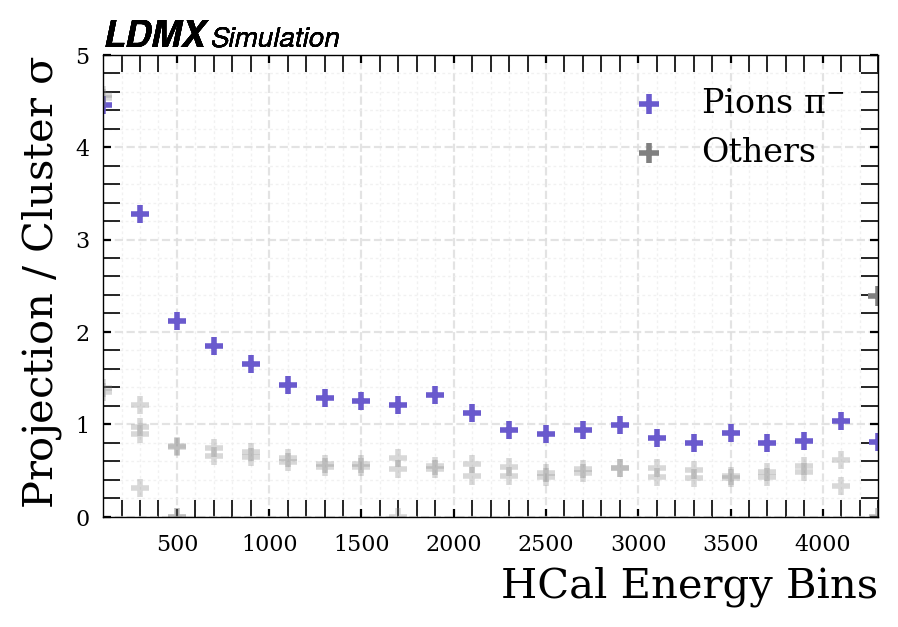

In [70]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['pions']
plot_clust_resolution_hcal(fig, ax, 'pions', binwidth=binwidth, erg_max=5e3, label=labels_dict['pions'])
plot_clust_resolution_hcal_others(fig, ax, part_particles_list, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 5)
ax.legend(fontsize=12)
plt.show()

### Protons

Axes limits [100.0, 4300.0] and [0.0, 1.3904256421923635]
Axes limits [100.0, 500.0] and [0.0, 4.5657983355522145]
Axes limits [100.0, 1700.0] and [0.0, 4.535809614181517]
Axes limits [100.0, 4700.0] and [0.0, 1.3491140794754028]
Axes limits [100.0, 4900.0] and [0.7965752128660677, 4.460953415632248]


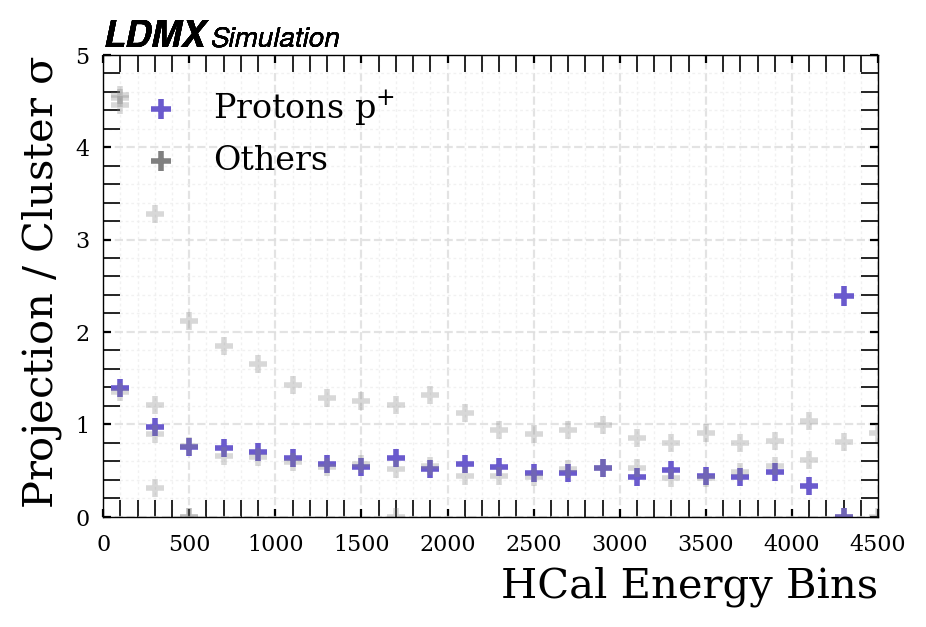

In [75]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['protons']
plot_clust_resolution_hcal(fig, ax, 'protons', binwidth=binwidth, erg_max=5e3, label=labels_dict['protons'])
plot_clust_resolution_hcal_others(fig, ax, part_particles_list, binwidth=binwidth, erg_max=5e3)
ax.set_xlim(0, 4500)
ax.set_ylim(0, 5)
ax.legend(fontsize=12, loc='upper left')
plt.show()

### Neutrons

Axes limits [100.0, 4700.0] and [0.0, 1.3491140794754028]
Axes limits [100.0, 500.0] and [0.0, 4.5657983355522145]
Axes limits [100.0, 1700.0] and [0.0, 4.535809614181517]
Axes limits [100.0, 4900.0] and [0.7965752128660677, 4.460953415632248]
Axes limits [100.0, 4300.0] and [0.0, 1.3904256421923635]


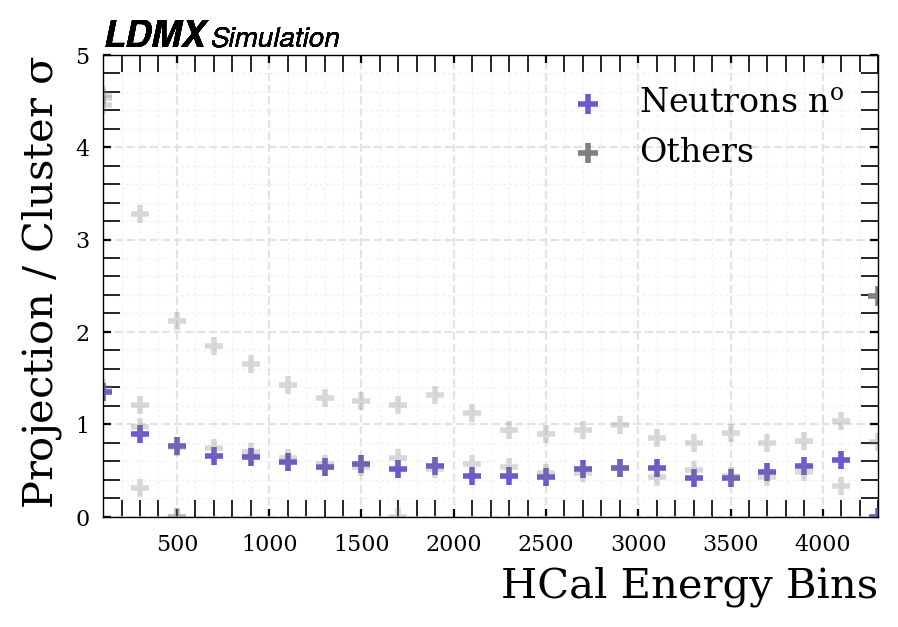

In [72]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
part_particles_list = ['neutrons']
plot_clust_resolution_hcal(fig, ax, 'neutrons', binwidth=binwidth, erg_max=5e3, label=labels_dict['neutrons'])
plot_clust_resolution_hcal_others(fig, ax, part_particles_list, binwidth=binwidth, erg_max=5e3)
ax.set_ylim(0, 5)
ax.legend(fontsize=12)
plt.show()